# Analysis for Beam

In [934]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random
from sympy import *
%matplotlib inline
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16
plt.rcParams["font.weight"] = "normal"
plt.rcParams.update({'figure.max_open_warning': 0})

In [935]:
class Beam():
    
    def __init__(self, **kwargs):
        # Parse Input Parameters
        for key, value in kwargs.items():
            if key == "k":
                self.k = value
            elif key == "delta0":
                self.delta0 = value
            elif key == "beta":
                self.beta = value
            elif key == "T0":
                self.T0 = value
            elif key == "T1":
                self.T1 = value
            elif key == "delta_T1":
                self.delta_T1 = value
            elif key == "theta":
                self.theta = value
            elif key == "R0": 
                self.R0 = value
            elif key == "T":
                self.T = value
            elif key == "R_T":
                self.R_T = value
            elif key == "phi":
                self.phi = value
            elif key == "B":
                self.B = value
            elif key == "H":
                self.H = value
            elif key == "mean_deadLoad":
                self.mean_deadLoad = value
            elif key == "variance_deadLoad":
                self.variance_deadLoad = value
            elif key == "mean_sustainedLoad":
                self.mean_sustainedLoad = value
            elif key == "variance_sustaineLoad":
                self.variance_sustaineLoad = value
            elif key == "beta_sustaintedLoad":
                self.beta_sustaintedLoad = value
            elif key == "mean_extroLoad":
                self.mean_extroLoad = value
            elif key == "variance_extroLoad":
                self.variance_extroLoad = value
            elif key == "beta_extroLoad":
                self.beta_extroLoad = value
            elif key == "load_duration":
                self.load_duration = value
            elif key == "L":
                self.L = value
            elif key == "b_t":
                self.b_t = value
            elif key == "alphaA":
                self.alphaA = value
            elif key == "alphaB":
                self.alphaB = value
        
        self.delta_T0 = self.k * self.delta0
        
    """
        PART 1 - Crack Depth (mm)
    """
    def calculateLambda(self):
        lam = ( (self.delta_T1 - self.delta_T0) * self.T0 ) / ( self.k * self.delta0 * (self.T1 - self.T0)**self.beta )
        self.lam = lam
        return lam
    
    def calculateDeltaT_year(self, duration_year=1000):
        deltaT = []
        duration_year = int(duration_year)
        if duration_year < self.T0:
            for year in range(duration_year):
                deltaT.append( self.k * self.delta0 * year / self.T0 )
                
        else:
            for year in range(duration_year):
                if year <= self.T0:
                    deltaT.append( self.k * self.delta0 * year / self.T0 )
                else:
                    deltaT.append( self.k * self.delta0 * (1 + self.lam * (year - self.T0)**self.beta / self.T0) )
            
        return deltaT
    
        
    def calculateDeltaT_day(self, duration_year=1000):
        deltaT_day = []
        deltaT_year = self.calculateDeltaT_year(duration_year)
        for delta in deltaT_year:
            deltaT_day += [delta] * 365
        return deltaT_day
    
    """
        PART 2 - Strength Degradation (Mpa)
    """
    def calculateA(self):
        a = ( 1 - self.R_T / self.R0 ) / ( self.T ** self.theta )
        self.a = a
        return a
    
    def calculateR_year(self, duration_year=1000):
        R_year = []
        for year in range(duration_year):
            R_year.append( self.R0 * (1 - self.a * year ** self.theta) )
        return R_year
    
    def calculateR_day(self, duration_year=1000):
        R_day = []
        R_year = self.calculateR_year(duration_year)
        for R in R_year:
            R_day += [R] * 365
        return R_day
    
    """
        PART 3 - Sigma S (Mpa)
    """
    def calculateSigmaS_year(self, duration_year=1000):
        sigmaS_year = []
        deltaT_year = self.calculateDeltaT_year(duration_year)
        R_year = self.calculateR_year(duration_year)
        for index in range(duration_year):
            w_eff = ((self.B - 2 * deltaT_year[index]/1000) * (self.H - 2 * deltaT_year[index]/1000) ** 2) / 6
            sigmaS_year.append(self.phi * R_year[index] * w_eff)
        return sigmaS_year
    
    def calculateSigmaS_day(self, duration_year=1000):
        sigmaS_day = []
        deltaT_day = self.calculateDeltaT_day(duration_year)
        R_day = self.calculateR_day(duration_year)
        for index in range(len(deltaT_day)):
            w_eff = ((self.B - 2 * deltaT_day[index]/1000) * (self.H - 2 * deltaT_day[index]/1000) ** 2) / 6
            sigmaS_day.append(self.phi * R_day[index] * w_eff)
        return sigmaS_day
    
    """
        PART 4 - Simulate Loads (kPa)
    """
    def calculateDeadLoadSingle(self):
        mu = self.mean_deadLoad
        sigma = math.sqrt(self.variance_deadLoad)
        deadLoadSingle = np.random.normal(mu, sigma, 1)[0]
        return deadLoadSingle
        
    def calculateSustainedLiveLoad_day(self, duration_year=1000):
        theta = self.variance_sustaineLoad / self.mean_sustainedLoad
        k = self.mean_sustainedLoad / theta
        timeLimit = 365 * duration_year
        currentTime = 0
        value = []
        sustainedTime = []
        sustainedLiveLoad_day = []
        while currentTime < timeLimit:
            value.append(np.random.gamma(k, theta, 1)[0])
            duration = int(np.random.exponential(self.beta_sustaintedLoad, 1)[0] * 365)
            sustainedTime.append(duration)
            currentTime += duration
        for index in range(len(sustainedTime)):
            sustainedLiveLoad_day += [value[index]] * sustainedTime[index]
        return sustainedLiveLoad_day[:duration_year*365]
    
    def calculateSustainedLiveLoad_year(self, duration_year=1000):
        sustainedLiveLoad_day = self.calculateSustainedLiveLoad_day(duration_year)
        sustainedLiveLoad_year = []
        for year in range(duration_year):
            sustainedLiveLoad_year.append(np.mean(sustainedLiveLoad_day[year*365: (year+1)*365]))
        return sustainedLiveLoad_year
    
    def calculateExtroLoad_day(self, duration_year=1000):
        theta = self.variance_extroLoad / self.mean_extroLoad
        k = self.mean_extroLoad / theta
        extroLiveLoad_day = [0] * 365 * 1000
        extroValue = []
        extroTime = []
        for i in range(duration_year):
            extroLive = np.random.gamma(k, theta, 1)[0]
            duration = random.randint(1, self.load_duration)
            occurance = int(np.random.exponential(self.beta_extroLoad, 1)[0])
            time = (np.random.random(occurance) * 365).astype(int)
            
            extroValue.append(extroLive)
            for item in time:
                extroTime.append(item + i*365)
            
            for startTime in time:
                for j in range(startTime, startTime + duration):
                    extroLiveLoad_day[i*365 + j] += extroLive
        extroLiveLoad_day = extroLiveLoad_day[:365 * duration_year]

        return extroLiveLoad_day
    
    def calculateExtroLoad_year(self, duration_year=1000):
        extroLiveLoad_day = self.calculateExtroLoad_day(duration_year)
        extroLiveLoad_year = []
        for year in range(duration_year):
            extroLiveLoad_year.append(np.mean(extroLiveLoad_day[year*365: (year+1)*365]))
        return extroLiveLoad_year
    
    """
        PART 5 - Sigma T (Mpa)
    """
    def calculateSigmaT_day(self, duration_year=1000):
        deadLoadSingle = self.calculateDeadLoadSingle()
        sustainedLive_day = self.calculateSustainedLiveLoad_day(duration_year)
        w = (np.array(sustainedLive_day) + deadLoadSingle)
        sigmaT_day = w * self.b_t * self.L**2 / 8 / 1000
        return sigmaT_day
    
    def calculateSigmaT_year(self, duration_year=1000):
        deadLoadSingle = self.calculateDeadLoadSingle()
        sustainedLive_year = self.calculateSustainedLiveLoad_year(duration_year)
        w = (np.array(sustainedLive_year) + deadLoadSingle)
        sigmaT_year = w * self.b_t * self.L**2 / 8 / 1000
        return sigmaT_year
    
    def calculateSigmaT(self, deadLoadSingle, sustainedLive):
        w = (np.array(sustainedLive) + deadLoadSingle) / 1000
        sigmaT = w * self.b_t * self.L**2 / 8
        return sigmaT
    
    """
        PART 6 - Damage Accumulation Alpha
    """
    def calculateAlpha(self, sigmaT, sigmaS):
        a = self.alphaA * np.log(10) / self.alphaB
        b = np.log(10) / self.alphaB
        alphaRate = []
        Alpha = []
        if len(list(sigmaT)) == len(list(sigmaS)):
            sigmaT = list(sigmaT)
            sigmaS = list(sigmaS)
            for index in range(len(list(sigmaT))):
                alphaRate.append( np.exp(-a + b * (sigmaT[index] / sigmaS[index])) )
            
            Alpha = np.cumsum(alphaRate)
            return alphaRate, Alpha
        else:
            print("LENGTH OF SIGMAT AND SIGMAS SHOULD BE THE SAME!")
        return alphaRate, Alpha
    

In [936]:
# INPUT PARAMETERS
params_beam = {
    "k" : 0.25,               # ========= DeltaT
    "delta0" : 4*1.06, 
    "beta": 2, 
    "T0" : 267, 
    "T1": 954, 
    "delta_T1": 16,           
    "theta": 2,             # ========= Strength Degradation
    "R0": 111.11, 
    "T": 921, 
    "R_T": 94.6,            
    "phi": 0.7,             # ========= SigmaS
    "B": 0.11,
    "H": 0.2,           
    "mean_deadLoad": 1.63,            # ========= Loads
    "variance_deadLoad": 0.1,
    "mean_sustainedLoad": 0.6, 
    "variance_sustaineLoad": 0.13, 
    "beta_sustaintedLoad": 10, 
    "mean_extroLoad": 0.5,
    "variance_extroLoad": 0.7478, 
    "beta_extroLoad": 10/3, 
    "load_duration": 5,
    "L": 6.9,                      # ========= Sigma T
    "b_t": 2.26, 
    "alphaA": 0.9,                      # ========= Alpha
    "alphaB": 0.0495
}

In [937]:
# Crack Depth
rectangular_beam = Beam(**params_beam)
lam = rectangular_beam.calculateLambda()
deltaT_year = rectangular_beam.calculateDeltaT_year(duration_year=1000)
deltaT_day = rectangular_beam.calculateDeltaT_day(duration_year=1000)

# Strength Degradation
a = rectangular_beam.calculateA()
R_year = rectangular_beam.calculateR_year(duration_year=1000)
R_day = rectangular_beam.calculateR_day(duration_year=1000)

# Sigma S
sigmaS_year = rectangular_beam.calculateSigmaS_year(duration_year=1000)
sigmaS_day = rectangular_beam.calculateSigmaS_day(duration_year=1000)

# Load
deadLoadSingle = rectangular_beam.calculateDeadLoadSingle()
sustainedLiveLoad_day = rectangular_beam.calculateSustainedLiveLoad_day(duration_year=1000)
sustainedLiveLoad_year = rectangular_beam.calculateSustainedLiveLoad_year(duration_year=1000)
extroLiveLoad_day = rectangular_beam.calculateExtroLoad_day(duration_year=1000)
extroLiveLoad_year = rectangular_beam.calculateExtroLoad_year(duration_year=1000)

# Sigma T
sigmaT_day = rectangular_beam.calculateSigmaT_day(duration_year=1000)
sigmaT_year = rectangular_beam.calculateSigmaT_year(duration_year=1000)

# AlphaRate and Alpha
alphaRate, Alpha = rectangular_beam.calculateAlpha(sigmaT=sigmaT_day, sigmaS=sigmaS_day)

# Figure Plotting

## 1 - Crack Depth

Text(0, 0.5, '')

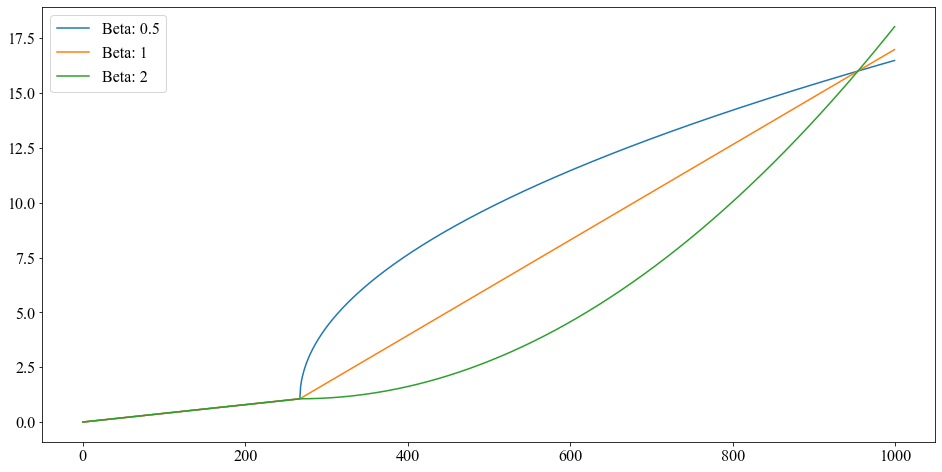

In [600]:
betaList = [0.5, 1, 2]
fig = plt.figure(figsize=(16, 8))
for beta in betaList:
    params_beam["beta"] = beta
    rectangular_beam = Beam(**params_beam)
    lam = rectangular_beam.calculateLambda()
    deltaT_year = rectangular_beam.calculateDeltaT_year(duration_year=1000)
    label = "Beta: " + str(beta)
    plt.plot(deltaT_year, label=label)
plt.legend()
plt.title("")
plt.xlabel("")
plt.ylabel("")

## 2 - Strength Degradation

Text(0, 0.5, '')

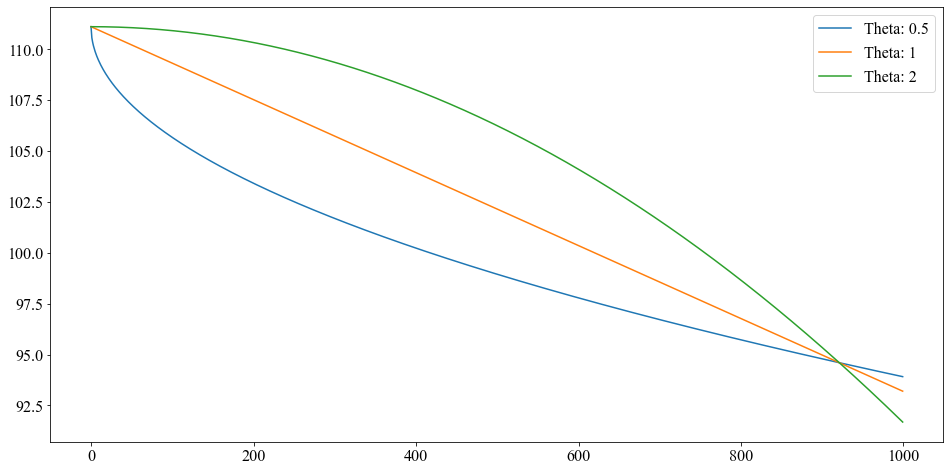

In [603]:
thetaList = [0.5, 1, 2]
fig = plt.figure(figsize=(16, 8))
for theta in thetaList:
    params_beam["theta"] = theta
    rectangular_beam = Beam(**params_beam)
    a = rectangular_beam.calculateA()
    R_year = rectangular_beam.calculateR_year(duration_year=1000)
    label = "Theta: " + str(theta)
    plt.plot(R_year, label=label)
plt.legend()
plt.title("")
plt.xlabel("")
plt.ylabel("")

## 3 - Sigma T & Sustained + Dead Load

Text(0.5, 1.0, '')

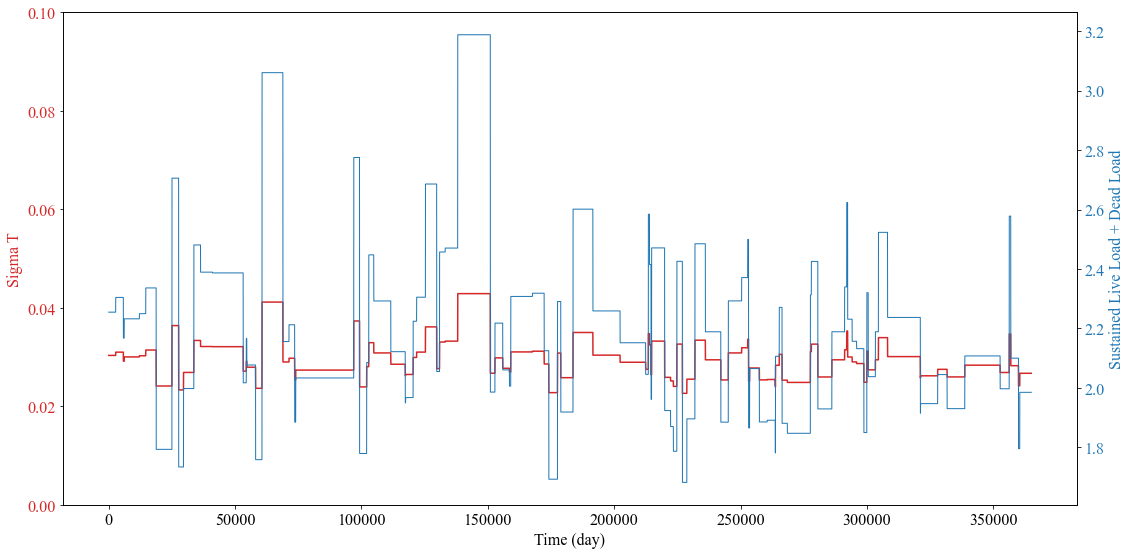

In [822]:
rectangular_beam = Beam(**params_beam)
deadLoadSingle = rectangular_beam.calculateDeadLoadSingle()
sustainedLiveLoad_day = rectangular_beam.calculateSustainedLiveLoad_day(duration_year=1000)
sigmaT_day = rectangular_beam.calculateSigmaT(deadLoadSingle, sustainedLiveLoad_day)

fig, ax1 = plt.subplots(figsize=(16, 8))

color = 'tab:red'
ax1.set_xlabel('Time (day)')
ax1.set_ylabel('Sigma T', color=color)
ax1.plot(sigmaT_day, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, 0.1)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Sustained Live Load + Dead Load', color=color)
ax2.plot(sustainedLiveLoad_day+deadLoadSingle, linewidth=1, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title("")

Text(0, 0.5, '')

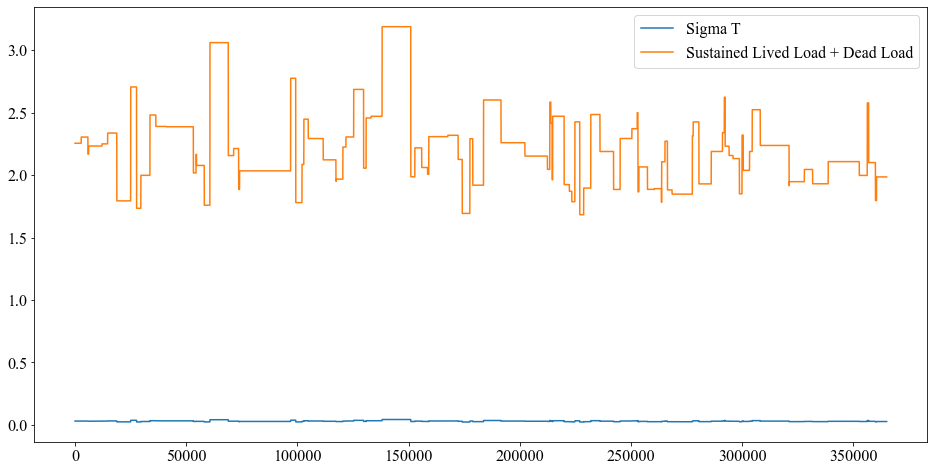

In [823]:
fig = plt.figure(figsize=(16, 8))
plt.plot(sigmaT_day, label="Sigma T")
plt.plot(sustainedLiveLoad_day+deadLoadSingle, label="Sustained Lived Load + Dead Load")
plt.legend()
plt.title("")
plt.xlabel("")
plt.ylabel("")

## 4 - Sustained + Dead + Extrodinary Load

Text(0, 0.5, '')

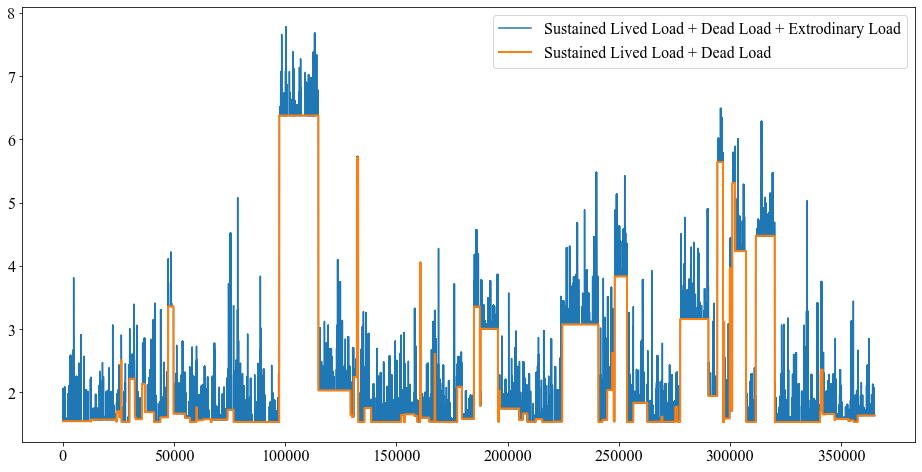

In [625]:
rectangular_beam = Beam(**params_beam)
deadLoadSingle = rectangular_beam.calculateDeadLoadSingle()
sustainedLiveLoad_day = rectangular_beam.calculateSustainedLiveLoad_day(duration_year=1000)
extroLiveLoad_day = rectangular_beam.calculateExtroLoad_day(duration_year=1000)

fig = plt.figure(figsize=(16, 8))
plt.plot(deadLoadSingle+sustainedLiveLoad_day+extroLiveLoad_day, label="Sustained Lived Load + Dead Load + Extrodinary Load")
plt.plot(deadLoadSingle+sustainedLiveLoad_day, linewidth=2, label="Sustained Lived Load + Dead Load")
plt.legend()
plt.title("")
plt.xlabel("")
plt.ylabel("")

## 5 - Sigma S

Text(0, 0.5, '')

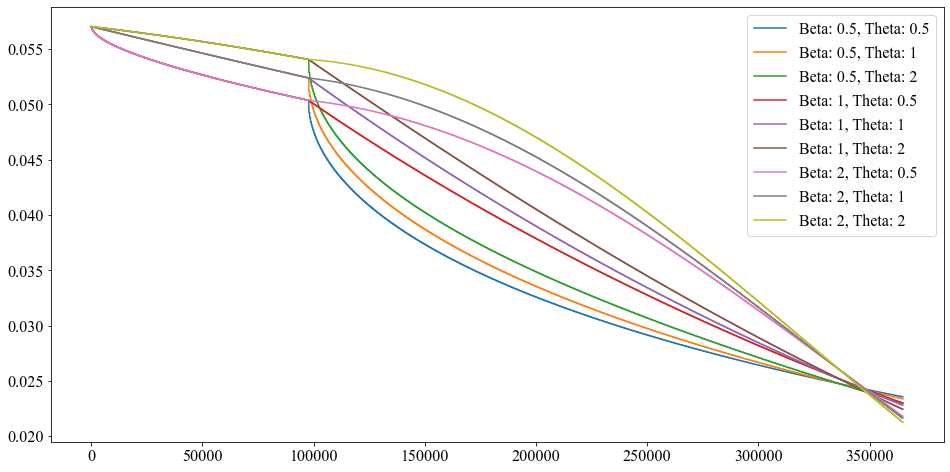

In [615]:
betaList = [0.5, 1, 2]
thetaList = [0.5, 1, 2]
fig = plt.figure(figsize=(16, 8))
for beta in betaList:
    for theta in thetaList:
        params_beam["beta"] = beta
        params_beam["theta"] = theta
        rectangular_beam = Beam(**params_beam)
        # Crack Depth
        lam = rectangular_beam.calculateLambda()
        deltaT_day = rectangular_beam.calculateDeltaT_day(duration_year=1000)
        # Strength Degradation
        a = rectangular_beam.calculateA()
        R_day = rectangular_beam.calculateR_day(duration_year=1000)
        sigmaS_day = rectangular_beam.calculateSigmaS_day(duration_year=1000)
        label = "Beta: " + str(beta) + ", Theta: " + str(theta)
        plt.plot(sigmaS_day, label=label)
plt.legend()
plt.title("")
plt.xlabel("")
plt.ylabel("")

Text(0, 0.5, '')

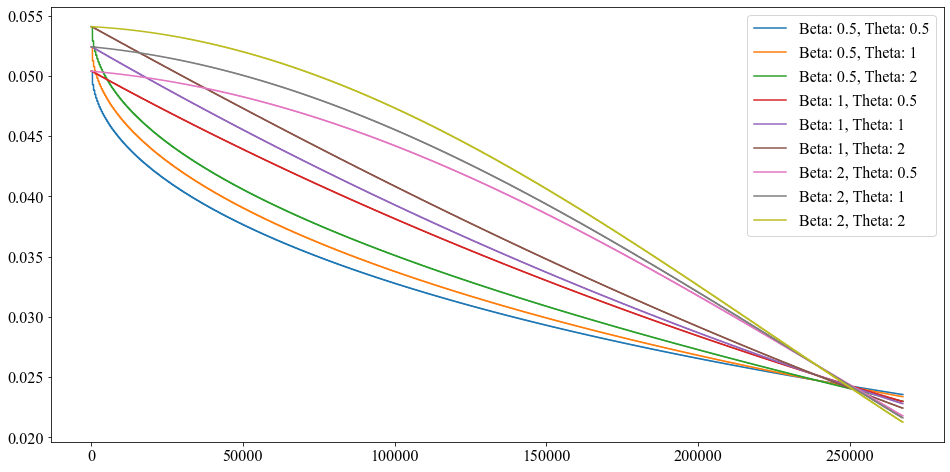

In [616]:
betaList = [0.5, 1, 2]
thetaList = [0.5, 1, 2]
fig = plt.figure(figsize=(16, 8))
for beta in betaList:
    for theta in thetaList:
        params_beam["beta"] = beta
        params_beam["theta"] = theta
        rectangular_beam = Beam(**params_beam)
        # Crack Depth
        lam = rectangular_beam.calculateLambda()
        deltaT_day = rectangular_beam.calculateDeltaT_day(duration_year=1000)
        # Strength Degradation
        a = rectangular_beam.calculateA()
        R_day = rectangular_beam.calculateR_day(duration_year=1000)
        sigmaS_day = rectangular_beam.calculateSigmaS_day(duration_year=1000)
        label = "Beta: " + str(beta) + ", Theta: " + str(theta)
        plt.plot(sigmaS_day[267*365:], label=label)
plt.legend()
plt.title("")
plt.xlabel("")
plt.ylabel("")

Text(0, 0.5, '')

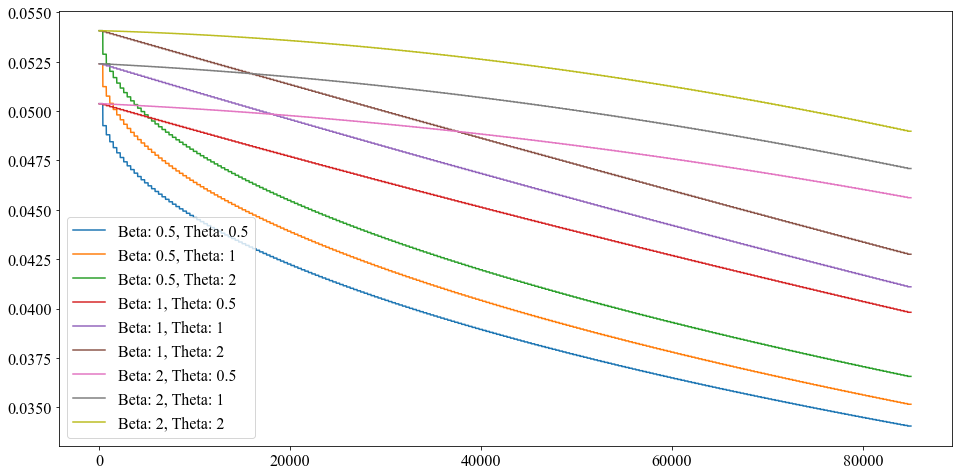

In [617]:
betaList = [0.5, 1, 2]
thetaList = [0.5, 1, 2]
fig = plt.figure(figsize=(16, 8))
for beta in betaList:
    for theta in thetaList:
        params_beam["beta"] = beta
        params_beam["theta"] = theta
        rectangular_beam = Beam(**params_beam)
        # Crack Depth
        lam = rectangular_beam.calculateLambda()
        deltaT_day = rectangular_beam.calculateDeltaT_day(duration_year=1000)
        # Strength Degradation
        a = rectangular_beam.calculateA()
        R_day = rectangular_beam.calculateR_day(duration_year=1000)
        sigmaS_day = rectangular_beam.calculateSigmaS_day(duration_year=1000)
        label = "Beta: " + str(beta) + ", Theta: " + str(theta)
        plt.plot(sigmaS_day[267*365:500*365], label=label)
plt.legend()
plt.title("")
plt.xlabel("")
plt.ylabel("")

## 6 - Extrodinary Load

Text(0, 0.5, '')

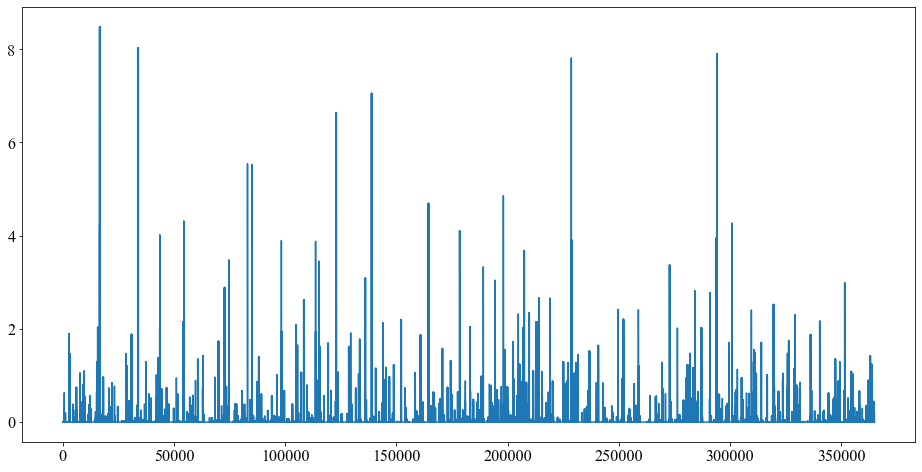

In [872]:
rectangular_beam = Beam(**params_beam)
extroLiveLoad_day = rectangular_beam.calculateExtroLoad_day(duration_year=1000)
fig = plt.figure(figsize=(16, 8))
plt.plot(extroLiveLoad_day)
plt.title("")
plt.xlabel("")
plt.ylabel("")

## 7 - Sigma T & Sigma S

Text(0, 0.5, '')

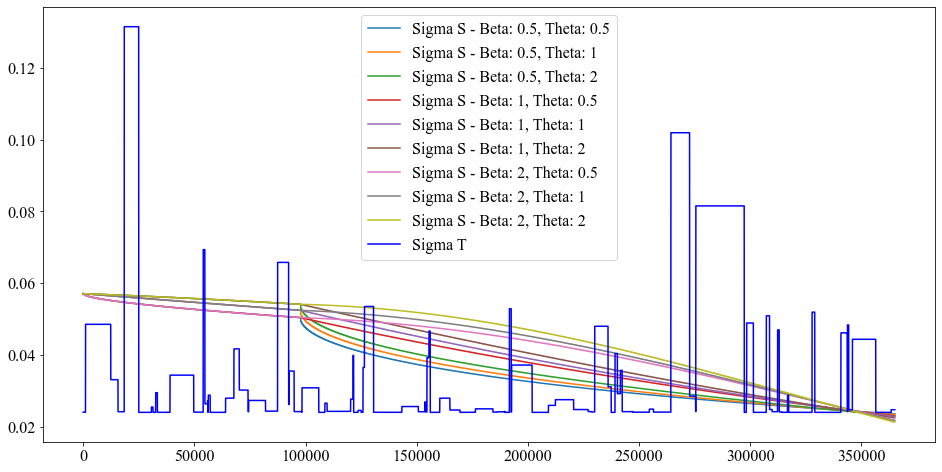

In [632]:
betaList = [0.5, 1, 2]
thetaList = [0.5, 1, 2]
fig = plt.figure(figsize=(16, 8))
for beta in betaList:
    for theta in thetaList:
        params_beam["beta"] = beta
        params_beam["theta"] = theta
        rectangular_beam = Beam(**params_beam)
        # Crack Depth
        lam = rectangular_beam.calculateLambda()
        deltaT_day = rectangular_beam.calculateDeltaT_day(duration_year=1000)
        # Strength Degradation
        a = rectangular_beam.calculateA()
        R_day = rectangular_beam.calculateR_day(duration_year=1000)
        sigmaS_day = rectangular_beam.calculateSigmaS_day(duration_year=1000)
        label = "Sigma S - Beta: " + str(beta) + ", Theta: " + str(theta)
        plt.plot(sigmaS_day, label=label)
        
deadLoadSingle = rectangular_beam.calculateDeadLoadSingle()
sustainedLiveLoad_day = rectangular_beam.calculateSustainedLiveLoad_day(duration_year=1000)
sigmaT_day = rectangular_beam.calculateSigmaT(deadLoadSingle, sustainedLiveLoad_day)
plt.plot(sigmaT_day, color='b', label="Sigma T")
plt.legend()
plt.title("")
plt.xlabel("")
plt.ylabel("")

## 8 - Alpha

Text(0, 0.5, '')

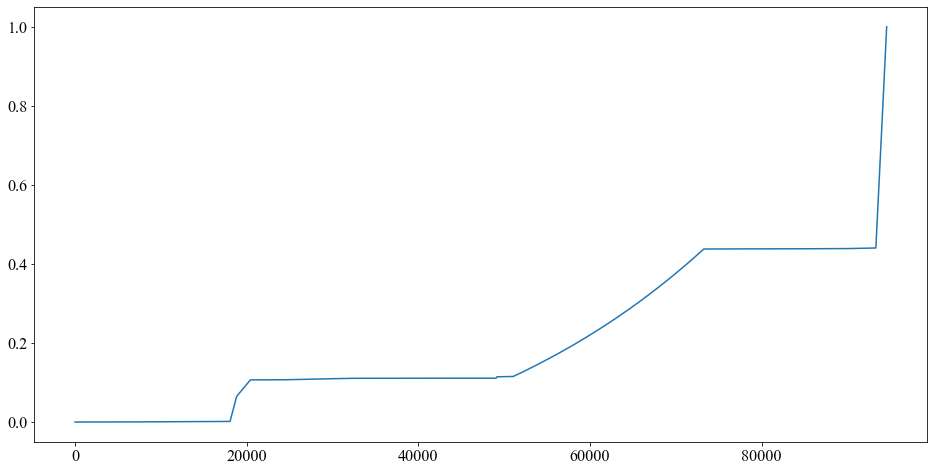

In [824]:
params_beam["beta"] = 0.5
params_beam["theta"] = 0.5
rectangular_beam = Beam(**params_beam)
# Crack Depth
lam = rectangular_beam.calculateLambda()
deltaT_day = rectangular_beam.calculateDeltaT_day(duration_year=1000)
# Strength Degradation
a = rectangular_beam.calculateA()
R_day = rectangular_beam.calculateR_day(duration_year=1000)
sigmaS_day = rectangular_beam.calculateSigmaS_day(duration_year=1000)

deadLoadSingle = rectangular_beam.calculateDeadLoadSingle()
sustainedLiveLoad_day = rectangular_beam.calculateSustainedLiveLoad_day(duration_year=1000)
sigmaT_day = rectangular_beam.calculateSigmaT(deadLoadSingle, sustainedLiveLoad_day)

# AlphaRate and Alpha
alphaRate, Alpha = rectangular_beam.calculateAlpha(sigmaT=sigmaT_day, sigmaS=sigmaS_day)

# Find Index When Alpha Bigger Than 1
for index in range(len(Alpha)):
    if Alpha[index] > 1.0:
        alphaIndex = index
        break
Alpha[alphaIndex:] = 1

fig = plt.figure(figsize=(16, 8))
plt.plot(Alpha[:alphaIndex])
plt.title("")
plt.xlabel("")
plt.ylabel("")

## 9 - Simulation for Alpha All Combination

In [715]:
simulationTimes = 1
betaList = [0.5, 1, 2]
thetaList = [0.5, 1, 2]
alphaIndex = {}
for time in range(simulationTimes):
    rectangular_beam1 = Beam(**params_beam)
    deadLoadSingle = rectangular_beam1.calculateDeadLoadSingle()
    sustainedLiveLoad_day = rectangular_beam1.calculateSustainedLiveLoad_day(duration_year=1000)
    sigmaT_day = rectangular_beam1.calculateSigmaT(deadLoadSingle, sustainedLiveLoad_day)
    print(f"Simulation Times: {time + 1}")
    for beta in betaList:
        for theta in thetaList:
            params_beam["beta"] = beta
            params_beam["theta"] = theta
            rectangular_beam = Beam(**params_beam)
            # Crack Depth
            lam = rectangular_beam.calculateLambda()
            deltaT_day = rectangular_beam.calculateDeltaT_day(duration_year=1000)
            # Strength Degradation
            a = rectangular_beam.calculateA()
            R_day = rectangular_beam.calculateR_day(duration_year=1000)
            sigmaS_day = rectangular_beam.calculateSigmaS_day(duration_year=1000)

            # AlphaRate and Alpha
            alphaRate, Alpha = rectangular_beam.calculateAlpha(sigmaT=sigmaT_day, sigmaS=sigmaS_day)
            # Find Index When Alpha Bigger Than 1
            for index in range(len(Alpha)):
                if Alpha[index] > 1.0:
                    if (beta, theta) in alphaIndex:
                        alphaIndex[(beta, theta)].append(index)
                    else:
                        alphaIndex[(beta, theta)] = []
                        alphaIndex[(beta, theta)].append(index)
                    break

Simulation Times: 1


## 10 - Simulation for Alpha - Beta: 0.5, Theta: 0.5

Simulation Times:  1
Simulation Times:  2
Simulation Times:  3
Simulation Times:  4
Simulation Times:  5
Simulation Times:  6
Simulation Times:  7
Simulation Times:  8
Simulation Times:  9
Simulation Times:  10
Simulation Times:  11
Simulation Times:  12
Simulation Times:  13
Simulation Times:  14
Simulation Times:  15
Simulation Times:  16
Simulation Times:  17
Simulation Times:  18
Simulation Times:  19
Simulation Times:  20
Simulation Times:  21
Simulation Times:  22
Simulation Times:  23
Simulation Times:  24
Simulation Times:  25
Simulation Times:  26
Simulation Times:  27
Simulation Times:  28
Simulation Times:  29
Simulation Times:  30
Simulation Times:  31
Simulation Times:  32
Simulation Times:  33
Simulation Times:  34
Simulation Times:  35
Simulation Times:  36
Simulation Times:  37
Simulation Times:  38
Simulation Times:  39
Simulation Times:  40
Simulation Times:  41
Simulation Times:  42
Simulation Times:  43
Simulation Times:  44
Simulation Times:  45
Simulation Times:  

<AxesSubplot:>

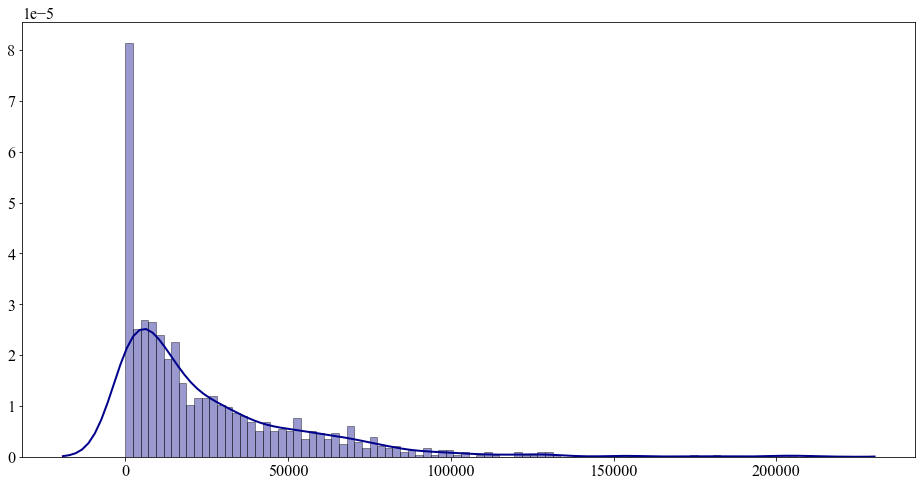

In [723]:
simulationTimes = 1000
alphaIndexAll = []
fig = plt.figure(figsize=(16, 8))

for time in range(simulationTimes):
    if time % 100 == 0:
        print("Simulation Times: ", time+1)
    params_beam["beta"] = 0.5
    params_beam["theta"] = 0.5
    rectangular_beam1 = Beam(**params_beam)
    deadLoadSingle = rectangular_beam1.calculateDeadLoadSingle()
    sustainedLiveLoad_day = rectangular_beam1.calculateSustainedLiveLoad_day(duration_year=1000)
    sigmaT_day = rectangular_beam.calculateSigmaT(deadLoadSingle, sustainedLiveLoad_day)
    # Crack Depth
    lam = rectangular_beam.calculateLambda()
    deltaT_day = rectangular_beam.calculateDeltaT_day(duration_year=1000)
    # Strength Degradation
    a = rectangular_beam.calculateA()
    R_day = rectangular_beam.calculateR_day(duration_year=1000)
    sigmaS_day = rectangular_beam.calculateSigmaS_day(duration_year=1000)
    # AlphaRate and Alpha
    alphaRate, Alpha = rectangular_beam.calculateAlpha(sigmaT=sigmaT_day, sigmaS=sigmaS_day)
    
    residualStrengthRatio = []
    for alpha in Alpha:
        residualStrengthRatio.append(1-alpha)
    
    # Find Index When Alpha Bigger Than 1
    for index in range(len(Alpha)):
        if Alpha[index] > 1.0:
            alphaIndex = index
            break
    alphaIndexAll.append(alphaIndex)
    averageAlphaIndex = np.mean(alphaIndexAll)
    
# Plot Distribution
# plt.hist(alphaIndexAll, bins=100, color="#0504aa", alpha=0.7, rwidth=0.85, density=True)
alphaIndexAll = list(filter(lambda num: num != 0, alphaIndexAll))
sns.distplot(alphaIndexAll, hist=True, kde=True, 
             bins=int(180/2), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})

Simulation Times:  1
Simulation Times:  101
Simulation Times:  201
Simulation Times:  301
Simulation Times:  401
Simulation Times:  501
Simulation Times:  601
Simulation Times:  701
Simulation Times:  801
Simulation Times:  901


<AxesSubplot:>

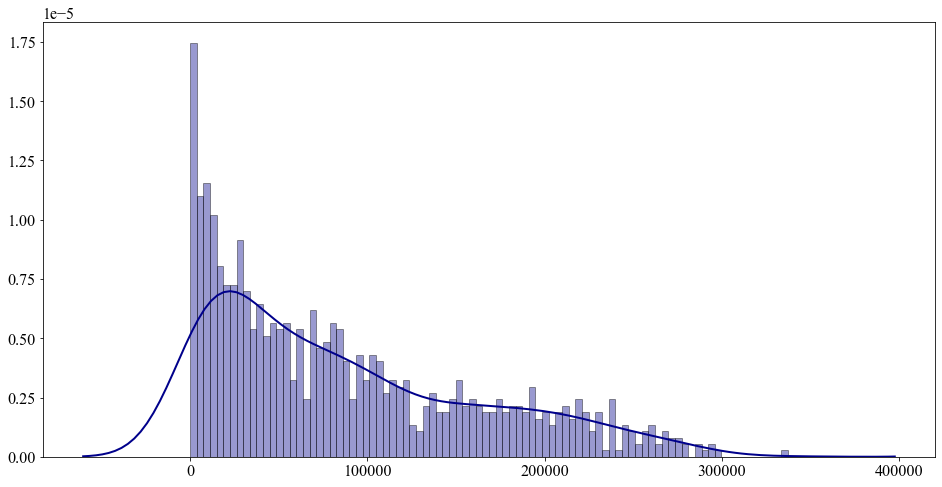

In [765]:
simulationTimes = 1000
alphaIndexAll = []
fig = plt.figure(figsize=(16, 8))

for time in range(simulationTimes):
    if time % 100 == 0:
        print("Simulation Times: ", time+1)
    params_beam["beta"] = 0.5
    params_beam["theta"] = 0.5
    rectangular_beam1 = Beam(**params_beam)
    deadLoadSingle = rectangular_beam1.calculateDeadLoadSingle()
    sustainedLiveLoad_day = rectangular_beam1.calculateSustainedLiveLoad_day(duration_year=1000)
    sigmaT_day = rectangular_beam.calculateSigmaT(deadLoadSingle, sustainedLiveLoad_day)
    # Crack Depth
    lam = rectangular_beam.calculateLambda()
    deltaT_day = rectangular_beam.calculateDeltaT_day(duration_year=1000)
    # Strength Degradation
    a = rectangular_beam.calculateA()
    R_day = rectangular_beam.calculateR_day(duration_year=1000)
    sigmaS_day = rectangular_beam.calculateSigmaS_day(duration_year=1000)
    # AlphaRate and Alpha
    alphaRate, Alpha = rectangular_beam.calculateAlpha(sigmaT=sigmaT_day, sigmaS=sigmaS_day)
    
    residualStrengthRatio = []
    for alpha in Alpha:
        residualStrengthRatio.append(1-alpha)
    
    # Find Index When Alpha Bigger Than 1
    for index in range(len(Alpha)):
        if Alpha[index] > 1.0:
            alphaIndex = index
            break
    alphaIndexAll.append(alphaIndex)
    averageAlphaIndex = np.mean(alphaIndexAll)
    
# Plot Distribution
# plt.hist(alphaIndexAll, bins=100, color="#0504aa", alpha=0.7, rwidth=0.85, density=True)
alphaIndexAllNonZero = list(filter(lambda num: num != 0, alphaIndexAll))
sns.distplot(alphaIndexAllNonZero, hist=True, kde=True, 
             bins=int(180/2), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})

### Simulate in Years

Simulation Times:  1
Simulation Times:  101
Simulation Times:  201
Simulation Times:  301
Simulation Times:  401
Simulation Times:  501
Simulation Times:  601
Simulation Times:  701
Simulation Times:  801
Simulation Times:  901

Average Year of Alpha Reaching 1: 292.848


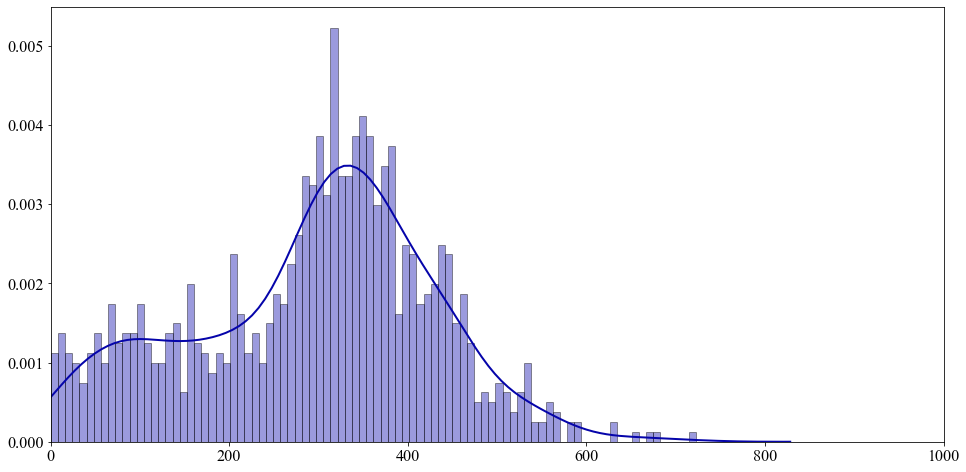

In [1020]:
simulationTimes = 1000
alphaIndexAll = []
fig = plt.figure(figsize=(16, 8))

for time in range(simulationTimes):
    if time % 100 == 0:
        print("Simulation Times: ", time+1)
    params_beam["beta"] = 0.5
    params_beam["theta"] = 0.5
    rectangular_beam1 = Beam(**params_beam)
    deadLoadSingle = rectangular_beam1.calculateDeadLoadSingle()
    sustainedLiveLoad_year = rectangular_beam1.calculateSustainedLiveLoad_year(duration_year=1000)
    sigmaT_year = rectangular_beam1.calculateSigmaT(deadLoadSingle, sustainedLiveLoad_year)
    
    rectangular_beam = Beam(**params_beam)
    # Crack Depth
    lam = rectangular_beam.calculateLambda()
    deltaT_year = rectangular_beam.calculateDeltaT_year(duration_year=1000)
    # Strength Degradation
    a = rectangular_beam.calculateA()
    R_year = rectangular_beam.calculateR_year(duration_year=1000)
    sigmaS_year = rectangular_beam.calculateSigmaS_year(duration_year=1000)
    # AlphaRate and Alpha
    alphaRate, Alpha = rectangular_beam.calculateAlpha(sigmaT=sigmaT_year, sigmaS=sigmaS_year)
    
    # Find Index When Alpha Bigger Than 1
    for index in range(len(Alpha)):
        if Alpha[index] > 1.0:
            alphaIndex = index
            break
    alphaIndexAll.append(alphaIndex)
    averageAlphaIndex = np.mean(alphaIndexAll)
    
# Plot Distribution
# plt.hist(alphaIndexAll, bins=100, color="#0504aa", alpha=0.7, rwidth=0.85, density=True)
# alphaIndexAllNonZero = list(filter(lambda num: num != 0, alphaIndexAll))
sns.distplot(alphaIndexAll, hist=True, kde=True, 
             bins=int(180/2), color = '#0504aa', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.xlim(0, 1000)
plt.title("")
plt.xlabel("")
plt.ylabel("")
print(f"\nAverage Year of Alpha Reaching 1: {np.mean(alphaIndexAll)}")
alphaIndexAllOrigin = alphaIndexAll


(0.0, 1.0)

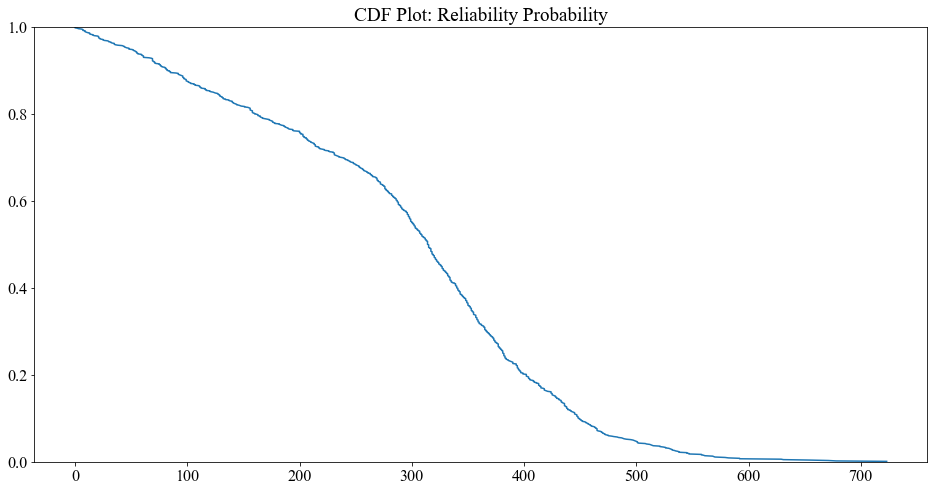

In [1026]:
# Plot Accumulated Probablity
plt.figure(figsize=(16, 8))
alphaIndexAllOrigin.sort()
N = len(alphaIndexAllOrigin)
y = np.arange(N) / float(N)
plt.plot(alphaIndexAllOrigin, 1 - y)
plt.title("CDF Plot: Reliability Probability")
plt.ylim(0, 1)

## 11 - Repairment Simulation: Threshold

Text(0, 0.5, '')

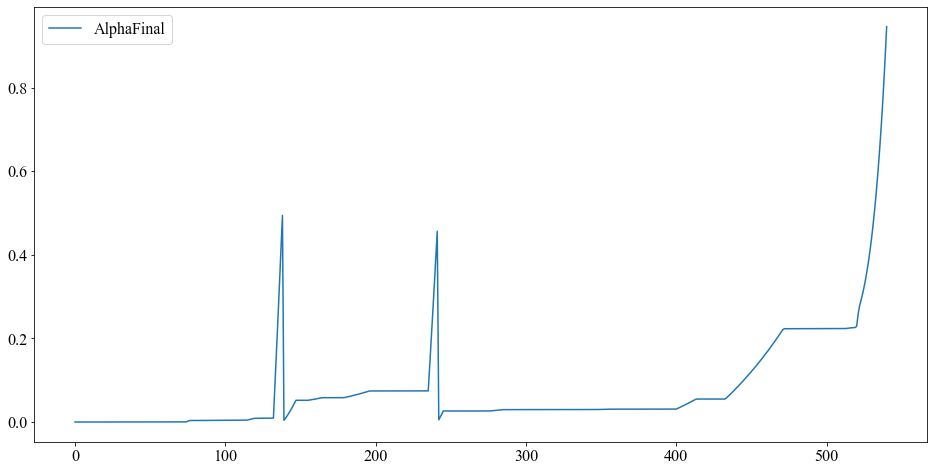

In [962]:
params_beam["beta"] = 0.5
params_beam["theta"] = 0.5
# >>>>>>>>>>>>>>>>>>>>>>
alphaThreshold = 0.5 #>>
# >>>>>>>>>>>>>>>>>>>>>>
alphaFinal = []

"""
- First Time Simulation
"""
rectangular_beam = Beam(**params_beam)
deadLoadSingle = rectangular_beam.calculateDeadLoadSingle()
sustainedLiveLoad_year = rectangular_beam.calculateSustainedLiveLoad_year(duration_year=6000)
sigmaT_year = rectangular_beam.calculateSigmaT(deadLoadSingle, sustainedLiveLoad_year)

# Crack Depth
lam = rectangular_beam.calculateLambda()
deltaT_year = rectangular_beam.calculateDeltaT_year(duration_year=2000)
# Strength Degradation
a = rectangular_beam.calculateA()
R_year = rectangular_beam.calculateR_year(duration_year=2000)
sigmaS_year = rectangular_beam.calculateSigmaS_year(duration_year=2000)
# AlphaRate and Alpha
alphaRate, Alpha = rectangular_beam.calculateAlpha(sigmaT=sigmaT_year[:2000], sigmaS=sigmaS_year)

for index in range(len(Alpha)):
    if Alpha[index] > alphaThreshold:
        alphaFirstIndex = index
        alphaFinal += list(Alpha[:alphaFirstIndex])
        break


"""
Second Time Simulation
"""
sigmaT_year2 = sigmaT_year[alphaFirstIndex:]
rectangular_beam2 = Beam(**params_beam)
# Crack Depth
lam2 = rectangular_beam2.calculateLambda()
deltaT_year2 = rectangular_beam2.calculateDeltaT_year(duration_year=2000)
# Strength Degradation
a2 = rectangular_beam2.calculateA()
R_year2 = rectangular_beam2.calculateR_year(duration_year=2000)
sigmaS_year2 = rectangular_beam2.calculateSigmaS_year(duration_year=2000)
# AlphaRate and Alpha
alphaRate2, Alpha2 = rectangular_beam2.calculateAlpha(sigmaT=sigmaT_year2[:2000], sigmaS=sigmaS_year2)

for index2 in range(len(Alpha2)):
    if Alpha2[index2] > alphaThreshold:
        alphaFirstIndex2 = index2
        alphaFinal += list(Alpha2[:alphaFirstIndex2])
        break

"""
Third Time Simulation
"""
sigmaT_year3 = sigmaT_year2[alphaFirstIndex2:]
rectangular_beam3 = Beam(**params_beam)
# Crack Depth
lam3 = rectangular_beam3.calculateLambda()
deltaT_year3 = rectangular_beam3.calculateDeltaT_year(duration_year=2000)
# Strength Degradation
a3 = rectangular_beam3.calculateA()
R_year3 = rectangular_beam3.calculateR_year(duration_year=2000)
sigmaS_year3 = rectangular_beam3.calculateSigmaS_year(duration_year=2000)
# AlphaRate and Alpha
alphaRate3, Alpha3 = rectangular_beam3.calculateAlpha(sigmaT=sigmaT_year3[:2000], sigmaS=sigmaS_year3)

for index3 in range(len(Alpha3)):
    if Alpha3[index3] > alphaThreshold:
        alphaFirstIndex3 = index3
#         alphaFinal += list(Alpha3[:alphaFirstIndex3])
        alphaFinal += list(Alpha3)
        break

# Find Index When AlphaFinal Reaches 1
for index in range(len(alphaFinal)):
    if alphaFinal[index] > 1:
        indexFinal = index
        break



fig = plt.figure(figsize=(16, 8))
plt.plot(alphaFinal[:indexFinal], label="AlphaFinal")
# plt.plot(Alpha[:alphaFirstIndex], label="First Alpha Segmentation")
# plt.plot(Alpha2[:alphaFirstIndex2], label="Second Alpha Segmentation")
# plt.plot(Alpha2[:alphaFirstIndex3], label="Third Alpha Segmentation")
plt.legend()
plt.title("")
plt.xlabel("")
plt.ylabel("")

## Repairment Simulation - 1000 Times

## Parameter Setting

### threshold = 0.5

Simulation Times:  1
Simulation Times:  101
Simulation Times:  201
Simulation Times:  301
Simulation Times:  401
Simulation Times:  501
Simulation Times:  601
Simulation Times:  701
Simulation Times:  801
Simulation Times:  901

Average Year of Alpha Reaching 1: 765.562


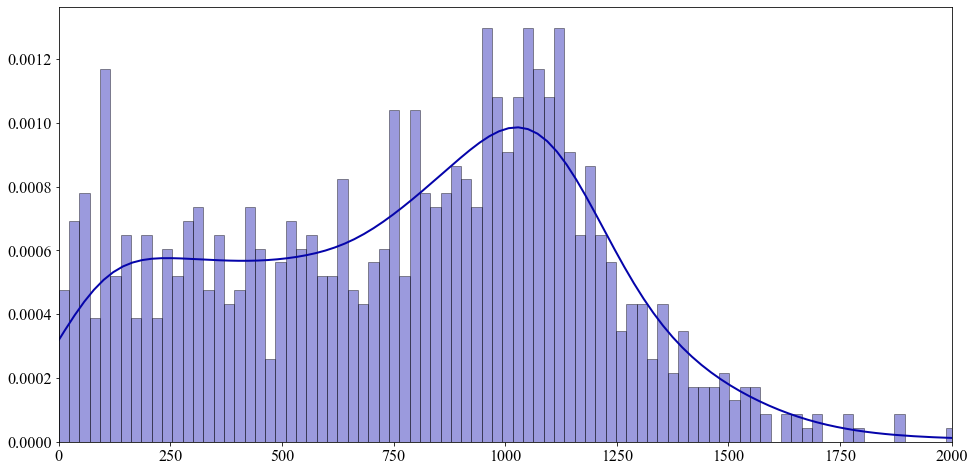

In [1056]:
simulationTimes = 1000
alphaIndexAll = []
fig = plt.figure(figsize=(16, 8))


for time in range(simulationTimes):
    if time % 100 == 0:
        print("Simulation Times: ", time+1)

    params_beam["beta"] = 0.5
    params_beam["theta"] = 0.5
    # >>>>>>>>>>>>>>>>>>>>>>>>
    alphaThreshold = 0.5  #>>>
    # >>>>>>>>>>>>>>>>>>>>>>>>
    alphaFinal = []

    """
    - First Time Simulation
    """
    rectangular_beam = Beam(**params_beam)
    deadLoadSingle = rectangular_beam.calculateDeadLoadSingle()
    sustainedLiveLoad_year = rectangular_beam.calculateSustainedLiveLoad_year(duration_year=6000)
    sigmaT_year = rectangular_beam.calculateSigmaT(deadLoadSingle, sustainedLiveLoad_year)

    # Crack Depth
    lam = rectangular_beam.calculateLambda()
    deltaT_year = rectangular_beam.calculateDeltaT_year(duration_year=2000)
    # Strength Degradation
    a = rectangular_beam.calculateA()
    R_year = rectangular_beam.calculateR_year(duration_year=2000)
    sigmaS_year = rectangular_beam.calculateSigmaS_year(duration_year=2000)
    # AlphaRate and Alpha
    alphaRate, Alpha = rectangular_beam.calculateAlpha(sigmaT=sigmaT_year[:2000], sigmaS=sigmaS_year)

    for index in range(len(Alpha)):
        if Alpha[index] > alphaThreshold:
            alphaFirstIndex = index
            alphaFinal += list(Alpha[:alphaFirstIndex])
            break


    """
    Second Time Simulation
    """
    sigmaT_year2 = sigmaT_year[alphaFirstIndex:]
    rectangular_beam2 = Beam(**params_beam)
    # Crack Depth
    lam2 = rectangular_beam2.calculateLambda()
    deltaT_year2 = rectangular_beam2.calculateDeltaT_year(duration_year=2000)
    # Strength Degradation
    a2 = rectangular_beam2.calculateA()
    R_year2 = rectangular_beam2.calculateR_year(duration_year=2000)
    sigmaS_year2 = rectangular_beam2.calculateSigmaS_year(duration_year=2000)
    # AlphaRate and Alpha
    alphaRate2, Alpha2 = rectangular_beam2.calculateAlpha(sigmaT=sigmaT_year2[:2000], sigmaS=sigmaS_year2)

    for index2 in range(len(Alpha2)):
        if Alpha2[index2] > alphaThreshold:
            alphaFirstIndex2 = index2
            alphaFinal += list(Alpha2[:alphaFirstIndex2])
            break

    """
    Third Time Simulation
    """
    sigmaT_year3 = sigmaT_year2[alphaFirstIndex2:]
    rectangular_beam3 = Beam(**params_beam)
    # Crack Depth
    lam3 = rectangular_beam3.calculateLambda()
    deltaT_year3 = rectangular_beam3.calculateDeltaT_year(duration_year=2000)
    # Strength Degradation
    a3 = rectangular_beam3.calculateA()
    R_year3 = rectangular_beam3.calculateR_year(duration_year=2000)
    sigmaS_year3 = rectangular_beam3.calculateSigmaS_year(duration_year=2000)
    # AlphaRate and Alpha
    alphaRate3, Alpha3 = rectangular_beam3.calculateAlpha(sigmaT=sigmaT_year3[:2000], sigmaS=sigmaS_year3)

    for index3 in range(len(Alpha3)):
        if Alpha3[index3] > alphaThreshold:
            alphaFirstIndex3 = index3
    #         alphaFinal += list(Alpha3[:alphaFirstIndex3])
            alphaFinal += list(Alpha3)
            break

    # Find Index When AlphaFinal Reaches 1
    for index in range(len(alphaFinal)):
        if alphaFinal[index] > 1:
            indexFinal = index
            break

    alphaIndexAll.append(indexFinal)

sns.distplot(alphaIndexAll, hist=True, kde=True, 
             bins=int(180/2), color = '#0504aa', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.xlim(0, 2000)
plt.title("")
plt.xlabel("")
plt.ylabel("")
print(f"\nAverage Year of Alpha Reaching 1: {np.mean(alphaIndexAll)}")

alphaIndexAllWithThresholdRepairment_twice = alphaIndexAll

### Threshold = 0.4

Simulation Times:  1
Simulation Times:  101
Simulation Times:  201
Simulation Times:  301
Simulation Times:  401
Simulation Times:  501
Simulation Times:  601
Simulation Times:  701
Simulation Times:  801
Simulation Times:  901

Average Year of Alpha Reaching 1: 765.454


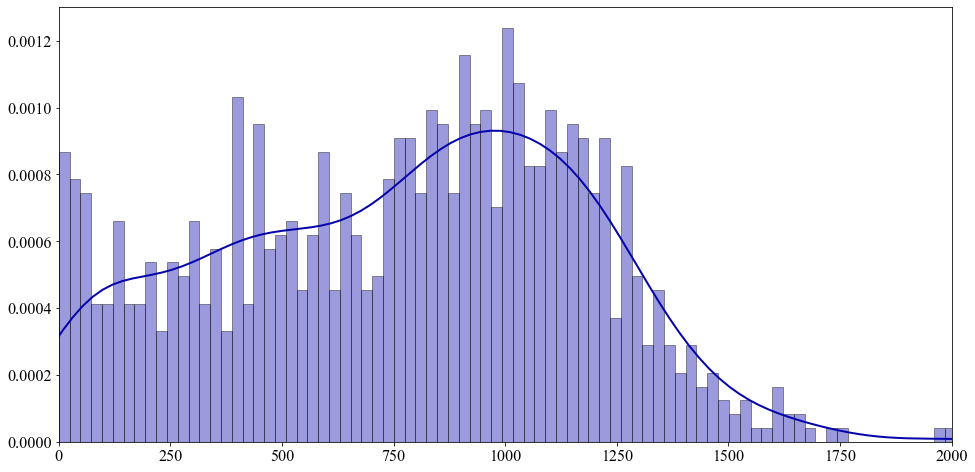

In [1057]:
simulationTimes = 1000
alphaIndexAll = []
fig = plt.figure(figsize=(16, 8))


for time in range(simulationTimes):
    if time % 100 == 0:
        print("Simulation Times: ", time+1)
    


    params_beam["beta"] = 0.5
    params_beam["theta"] = 0.5
    # >>>>>>>>>>>>>>>>>>>>>>>>
    alphaThreshold = 0.4  # >>
    # >>>>>>>>>>>>>>>>>>>>>>>>
    alphaFinal = []

    """
    - First Time Simulation
    """
    rectangular_beam = Beam(**params_beam)
    deadLoadSingle = rectangular_beam.calculateDeadLoadSingle()
    sustainedLiveLoad_year = rectangular_beam.calculateSustainedLiveLoad_year(duration_year=6000)
    sigmaT_year = rectangular_beam.calculateSigmaT(deadLoadSingle, sustainedLiveLoad_year)

    # Crack Depth
    lam = rectangular_beam.calculateLambda()
    deltaT_year = rectangular_beam.calculateDeltaT_year(duration_year=2000)
    # Strength Degradation
    a = rectangular_beam.calculateA()
    R_year = rectangular_beam.calculateR_year(duration_year=2000)
    sigmaS_year = rectangular_beam.calculateSigmaS_year(duration_year=2000)
    # AlphaRate and Alpha
    alphaRate, Alpha = rectangular_beam.calculateAlpha(sigmaT=sigmaT_year[:2000], sigmaS=sigmaS_year)

    for index in range(len(Alpha)):
        if Alpha[index] > alphaThreshold:
            alphaFirstIndex = index
            alphaFinal += list(Alpha[:alphaFirstIndex])
            break


    """
    Second Time Simulation
    """
    sigmaT_year2 = sigmaT_year[alphaFirstIndex:]
    rectangular_beam2 = Beam(**params_beam)
    # Crack Depth
    lam2 = rectangular_beam2.calculateLambda()
    deltaT_year2 = rectangular_beam2.calculateDeltaT_year(duration_year=2000)
    # Strength Degradation
    a2 = rectangular_beam2.calculateA()
    R_year2 = rectangular_beam2.calculateR_year(duration_year=2000)
    sigmaS_year2 = rectangular_beam2.calculateSigmaS_year(duration_year=2000)
    # AlphaRate and Alpha
    alphaRate2, Alpha2 = rectangular_beam2.calculateAlpha(sigmaT=sigmaT_year2[:2000], sigmaS=sigmaS_year2)

    for index2 in range(len(Alpha2)):
        if Alpha2[index2] > alphaThreshold:
            alphaFirstIndex2 = index2
            alphaFinal += list(Alpha2[:alphaFirstIndex2])
            break

    """
    Third Time Simulation
    """
    sigmaT_year3 = sigmaT_year2[alphaFirstIndex2:]
    rectangular_beam3 = Beam(**params_beam)
    # Crack Depth
    lam3 = rectangular_beam3.calculateLambda()
    deltaT_year3 = rectangular_beam3.calculateDeltaT_year(duration_year=2000)
    # Strength Degradation
    a3 = rectangular_beam3.calculateA()
    R_year3 = rectangular_beam3.calculateR_year(duration_year=2000)
    sigmaS_year3 = rectangular_beam3.calculateSigmaS_year(duration_year=2000)
    # AlphaRate and Alpha
    alphaRate3, Alpha3 = rectangular_beam3.calculateAlpha(sigmaT=sigmaT_year3[:2000], sigmaS=sigmaS_year3)

    for index3 in range(len(Alpha3)):
        if Alpha3[index3] > alphaThreshold:
            alphaFirstIndex3 = index3
    #         alphaFinal += list(Alpha3[:alphaFirstIndex3])
            alphaFinal += list(Alpha3)
            break

    # Find Index When AlphaFinal Reaches 1
    for index in range(len(alphaFinal)):
        if alphaFinal[index] > 1:
            indexFinal = index
            break

    alphaIndexAll.append(indexFinal)

sns.distplot(alphaIndexAll, hist=True, kde=True, 
             bins=int(180/2), color = '#0504aa', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.xlim(0, 2000)
plt.title("")
plt.xlabel("")
plt.ylabel("")
print(f"\nAverage Year of Alpha Reaching 1: {np.mean(alphaIndexAll)}")

alphaIndexAllWithThresholdRepairment_4_twice = alphaIndexAll

### Threshold = 0.3

Simulation Times:  1
Simulation Times:  101
Simulation Times:  201
Simulation Times:  301
Simulation Times:  401
Simulation Times:  501
Simulation Times:  601
Simulation Times:  701
Simulation Times:  801
Simulation Times:  901

Average Year of Alpha Reaching 1: 778.68


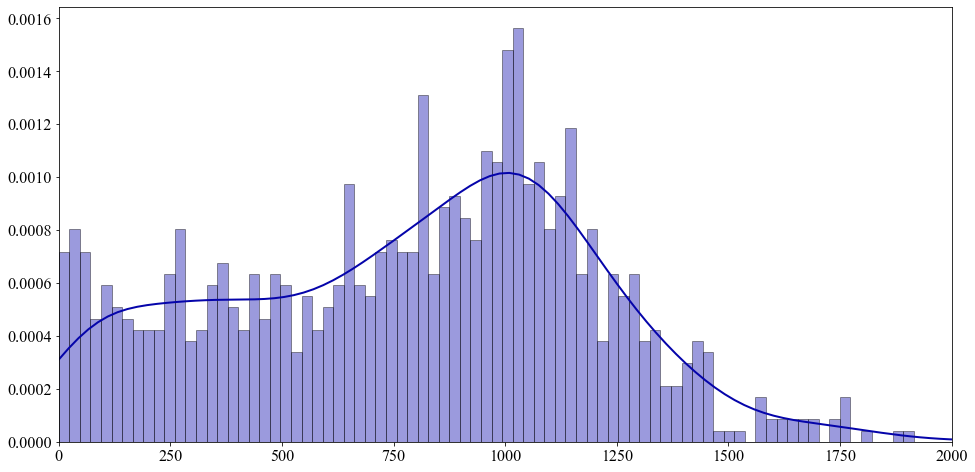

In [1058]:
simulationTimes = 1000
alphaIndexAll = []
fig = plt.figure(figsize=(16, 8))


for time in range(simulationTimes):
    if time % 100 == 0:
        print("Simulation Times: ", time+1)
    


    params_beam["beta"] = 0.5
    params_beam["theta"] = 0.5
    # >>>>>>>>>>>>>>>>>>>>>>>>>
    alphaThreshold = 0.3  # >>>
    # >>>>>>>>>>>>>>>>>>>>>>>>>
    alphaFinal = []

    """
    - First Time Simulation
    """
    rectangular_beam = Beam(**params_beam)
    deadLoadSingle = rectangular_beam.calculateDeadLoadSingle()
    sustainedLiveLoad_year = rectangular_beam.calculateSustainedLiveLoad_year(duration_year=6000)
    sigmaT_year = rectangular_beam.calculateSigmaT(deadLoadSingle, sustainedLiveLoad_year)

    # Crack Depth
    lam = rectangular_beam.calculateLambda()
    deltaT_year = rectangular_beam.calculateDeltaT_year(duration_year=2000)
    # Strength Degradation
    a = rectangular_beam.calculateA()
    R_year = rectangular_beam.calculateR_year(duration_year=2000)
    sigmaS_year = rectangular_beam.calculateSigmaS_year(duration_year=2000)
    # AlphaRate and Alpha
    alphaRate, Alpha = rectangular_beam.calculateAlpha(sigmaT=sigmaT_year[:2000], sigmaS=sigmaS_year)

    for index in range(len(Alpha)):
        if Alpha[index] > alphaThreshold:
            alphaFirstIndex = index
            alphaFinal += list(Alpha[:alphaFirstIndex])
            break


    """
    Second Time Simulation
    """
    sigmaT_year2 = sigmaT_year[alphaFirstIndex:]
    rectangular_beam2 = Beam(**params_beam)
    # Crack Depth
    lam2 = rectangular_beam2.calculateLambda()
    deltaT_year2 = rectangular_beam2.calculateDeltaT_year(duration_year=2000)
    # Strength Degradation
    a2 = rectangular_beam2.calculateA()
    R_year2 = rectangular_beam2.calculateR_year(duration_year=2000)
    sigmaS_year2 = rectangular_beam2.calculateSigmaS_year(duration_year=2000)
    # AlphaRate and Alpha
    alphaRate2, Alpha2 = rectangular_beam2.calculateAlpha(sigmaT=sigmaT_year2[:2000], sigmaS=sigmaS_year2)

    for index2 in range(len(Alpha2)):
        if Alpha2[index2] > alphaThreshold:
            alphaFirstIndex2 = index2
            alphaFinal += list(Alpha2[:alphaFirstIndex2])
            break

    """
    Third Time Simulation
    """
    sigmaT_year3 = sigmaT_year2[alphaFirstIndex2:]
    rectangular_beam3 = Beam(**params_beam)
    # Crack Depth
    lam3 = rectangular_beam3.calculateLambda()
    deltaT_year3 = rectangular_beam3.calculateDeltaT_year(duration_year=2000)
    # Strength Degradation
    a3 = rectangular_beam3.calculateA()
    R_year3 = rectangular_beam3.calculateR_year(duration_year=2000)
    sigmaS_year3 = rectangular_beam3.calculateSigmaS_year(duration_year=2000)
    # AlphaRate and Alpha
    alphaRate3, Alpha3 = rectangular_beam3.calculateAlpha(sigmaT=sigmaT_year3[:2000], sigmaS=sigmaS_year3)

    for index3 in range(len(Alpha3)):
        if Alpha3[index3] > alphaThreshold:
            alphaFirstIndex3 = index3
    #         alphaFinal += list(Alpha3[:alphaFirstIndex3])
            alphaFinal += list(Alpha3)
            break

    # Find Index When AlphaFinal Reaches 1
    for index in range(len(alphaFinal)):
        if alphaFinal[index] > 1:
            indexFinal = index
            break

    alphaIndexAll.append(indexFinal)

sns.distplot(alphaIndexAll, hist=True, kde=True, 
             bins=int(180/2), color = '#0504aa', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.xlim(0, 2000)
plt.title("")
plt.xlabel("")
plt.ylabel("")
print(f"\nAverage Year of Alpha Reaching 1: {np.mean(alphaIndexAll)}")

alphaIndexAllWithThresholdRepairment_3_twice = alphaIndexAll

## 12 - Comparison Between Original and With Repairment (Threshold)

Text(0, 0.5, '')

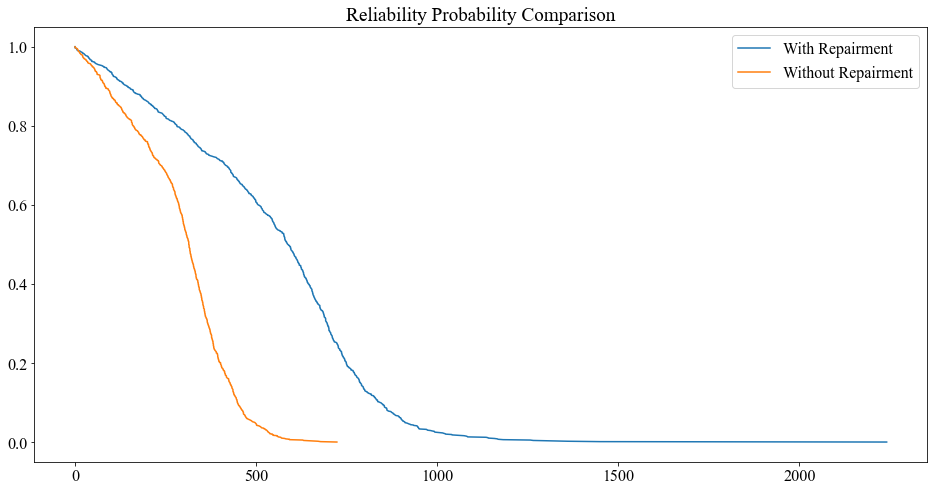

In [1059]:
# CDF Figure
fig = plt.figure(figsize=(16, 8))
alphaIndexAllWithThresholdRepairment.sort()
N1 = len(alphaIndexAllWithThresholdRepairment)
y1 = np.arange(N1) / float(N1)
plt.plot(alphaIndexAllWithThresholdRepairment, 1 - y1, label="With Repairment")

alphaIndexAllOrigin.sort()
N2 = len(alphaIndexAllOrigin)
y2 = np.arange(N2) / float(N2)
plt.plot(alphaIndexAllOrigin, 1 - y, label="Without Repairment")

plt.legend()
plt.title("Reliability Probability Comparison")
plt.xlabel("")
plt.ylabel("")

## 13 - Repairment Simulation - Every 40 Years

Text(0, 0.5, '')

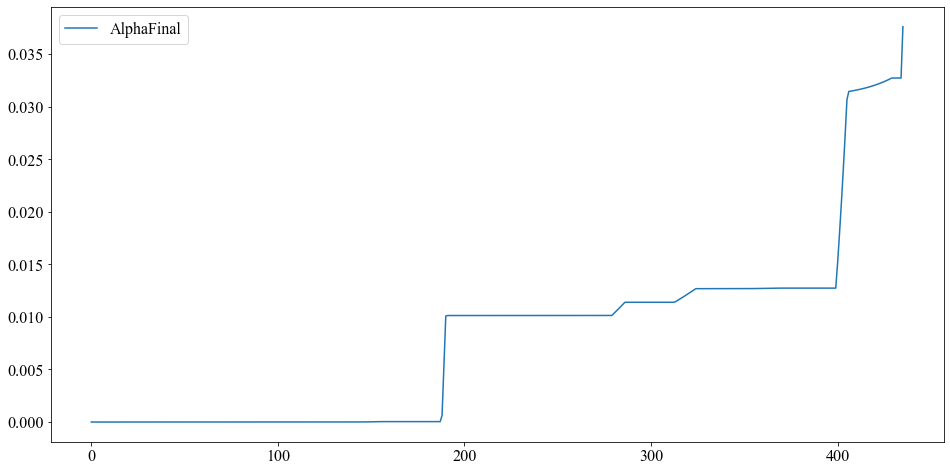

In [1060]:
params_beam["beta"] = 0.5
params_beam["theta"] = 0.5
# >>>>>>>>>>>>>>>>>
repairGap = 40  #>>
# >>>>>>>>>>>>>>>>>
alphaFinal = []

"""
- First Time Simulation
"""
rectangular_beam = Beam(**params_beam)
deadLoadSingle = rectangular_beam.calculateDeadLoadSingle()
sustainedLiveLoad_year = rectangular_beam.calculateSustainedLiveLoad_year(duration_year=6000)
sigmaT_year = rectangular_beam.calculateSigmaT(deadLoadSingle, sustainedLiveLoad_year)

# Crack Depth
lam = rectangular_beam.calculateLambda()
deltaT_year = rectangular_beam.calculateDeltaT_year(duration_year=2000)
# Strength Degradation
a = rectangular_beam.calculateA()
R_year = rectangular_beam.calculateR_year(duration_year=2000)
sigmaS_year = rectangular_beam.calculateSigmaS_year(duration_year=2000)
# AlphaRate and Alpha
alphaRate, Alpha = rectangular_beam.calculateAlpha(sigmaT=sigmaT_year[:2000], sigmaS=sigmaS_year)

alphaFinal += list(Alpha[:repairGap])


"""
Second Time Simulation
"""
sigmaT_year2 = sigmaT_year[repairGap:]
rectangular_beam2 = Beam(**params_beam)
# Crack Depth
lam2 = rectangular_beam2.calculateLambda()
deltaT_year2 = rectangular_beam2.calculateDeltaT_year(duration_year=2000)
# Strength Degradation
a2 = rectangular_beam2.calculateA()
R_year2 = rectangular_beam2.calculateR_year(duration_year=2000)
sigmaS_year2 = rectangular_beam2.calculateSigmaS_year(duration_year=2000)
# AlphaRate and Alpha
alphaRate2, Alpha2 = rectangular_beam2.calculateAlpha(sigmaT=sigmaT_year2[:2000], sigmaS=sigmaS_year2)

alphaFinal += list(Alpha2[:repairGap])

"""
Third Time Simulation
"""
sigmaT_year3 = sigmaT_year2[alphaFirstIndex2:]
rectangular_beam3 = Beam(**params_beam)
# Crack Depth
lam3 = rectangular_beam3.calculateLambda()
deltaT_year3 = rectangular_beam3.calculateDeltaT_year(duration_year=2000)
# Strength Degradation
a3 = rectangular_beam3.calculateA()
R_year3 = rectangular_beam3.calculateR_year(duration_year=2000)
sigmaS_year3 = rectangular_beam3.calculateSigmaS_year(duration_year=2000)
# AlphaRate and Alpha
alphaRate3, Alpha3 = rectangular_beam3.calculateAlpha(sigmaT=sigmaT_year3[:2000], sigmaS=sigmaS_year3)

alphaFinal += list(Alpha3)

# Find Index When AlphaFinal Reaches 1
for index in range(len(alphaFinal)):
    if alphaFinal[index] > 1:
        indexFinal = index
        break



fig = plt.figure(figsize=(16, 8))
plt.plot(alphaFinal[:indexFinal], label="AlphaFinal")
# plt.plot(Alpha[:indexFinal])
# plt.plot(Alpha[:alphaFirstIndex], label="First Alpha Segmentation")
# plt.plot(Alpha2[:alphaFirstIndex2], label="Second Alpha Segmentation")
# plt.plot(Alpha2[:alphaFirstIndex3], label="Third Alpha Segmentation")
plt.legend()
plt.title("")
plt.xlabel("")
plt.ylabel("")

Simulation Times:  1
Simulation Times:  101
Simulation Times:  201
Simulation Times:  301
Simulation Times:  401
Simulation Times:  501
Simulation Times:  601
Simulation Times:  701
Simulation Times:  801
Simulation Times:  901

Average Year of Alpha Reaching 1: 363.49


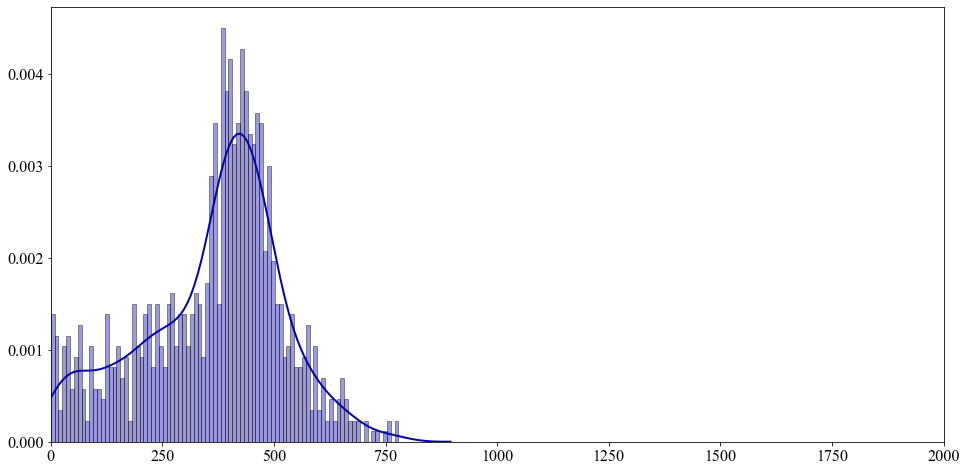

In [1061]:
simulationTimes = 1000
alphaIndexAll = []
fig = plt.figure(figsize=(16, 8))

for time in range(simulationTimes):
    if time % 100 == 0:
        print("Simulation Times: ", time+1)
        
    params_beam["beta"] = 0.5
    params_beam["theta"] = 0.5
    # >>>>>>>>>>>>>>>>>
    repairGap = 40  #>>
    # >>>>>>>>>>>>>>>>>
    alphaFinal = []

    """
    - First Time Simulation
    """
    rectangular_beam = Beam(**params_beam)
    deadLoadSingle = rectangular_beam.calculateDeadLoadSingle()
    sustainedLiveLoad_year = rectangular_beam.calculateSustainedLiveLoad_year(duration_year=6000)
    sigmaT_year = rectangular_beam.calculateSigmaT(deadLoadSingle, sustainedLiveLoad_year)

    # Crack Depth
    lam = rectangular_beam.calculateLambda()
    deltaT_year = rectangular_beam.calculateDeltaT_year(duration_year=2000)
    # Strength Degradation
    a = rectangular_beam.calculateA()
    R_year = rectangular_beam.calculateR_year(duration_year=2000)
    sigmaS_year = rectangular_beam.calculateSigmaS_year(duration_year=2000)
    # AlphaRate and Alpha
    alphaRate, Alpha = rectangular_beam.calculateAlpha(sigmaT=sigmaT_year[:2000], sigmaS=sigmaS_year)

    alphaFinal += list(Alpha[:repairGap])


    """
    Second Time Simulation
    """
    sigmaT_year2 = sigmaT_year[repairGap:]
    rectangular_beam2 = Beam(**params_beam)
    # Crack Depth
    lam2 = rectangular_beam2.calculateLambda()
    deltaT_year2 = rectangular_beam2.calculateDeltaT_year(duration_year=2000)
    # Strength Degradation
    a2 = rectangular_beam2.calculateA()
    R_year2 = rectangular_beam2.calculateR_year(duration_year=2000)
    sigmaS_year2 = rectangular_beam2.calculateSigmaS_year(duration_year=2000)
    # AlphaRate and Alpha
    alphaRate2, Alpha2 = rectangular_beam2.calculateAlpha(sigmaT=sigmaT_year2[:2000], sigmaS=sigmaS_year2)

    alphaFinal += list(Alpha2[:repairGap])

    """
    Third Time Simulation
    """
    sigmaT_year3 = sigmaT_year2[alphaFirstIndex2:]
    rectangular_beam3 = Beam(**params_beam)
    # Crack Depth
    lam3 = rectangular_beam3.calculateLambda()
    deltaT_year3 = rectangular_beam3.calculateDeltaT_year(duration_year=2000)
    # Strength Degradation
    a3 = rectangular_beam3.calculateA()
    R_year3 = rectangular_beam3.calculateR_year(duration_year=2000)
    sigmaS_year3 = rectangular_beam3.calculateSigmaS_year(duration_year=2000)
    # AlphaRate and Alpha
    alphaRate3, Alpha3 = rectangular_beam3.calculateAlpha(sigmaT=sigmaT_year3[:2000], sigmaS=sigmaS_year3)

    alphaFinal += list(Alpha3)

    # Find Index When AlphaFinal Reaches 1
    for index in range(len(alphaFinal)):
        if alphaFinal[index] > 1:
            indexFinal = index
            break

    alphaIndexAll.append(indexFinal)

sns.distplot(alphaIndexAll, hist=True, kde=True, 
             bins=int(180/2), color = '#0504aa', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.xlim(0, 2000)
plt.title("")
plt.xlabel("")
plt.ylabel("")
print(f"\nAverage Year of Alpha Reaching 1: {np.mean(alphaIndexAll)}")

alphaIndexAllFourtyYearRepairment_twice = alphaIndexAll

## Repairment Simulation - Every 5 Years

Text(0, 0.5, '')

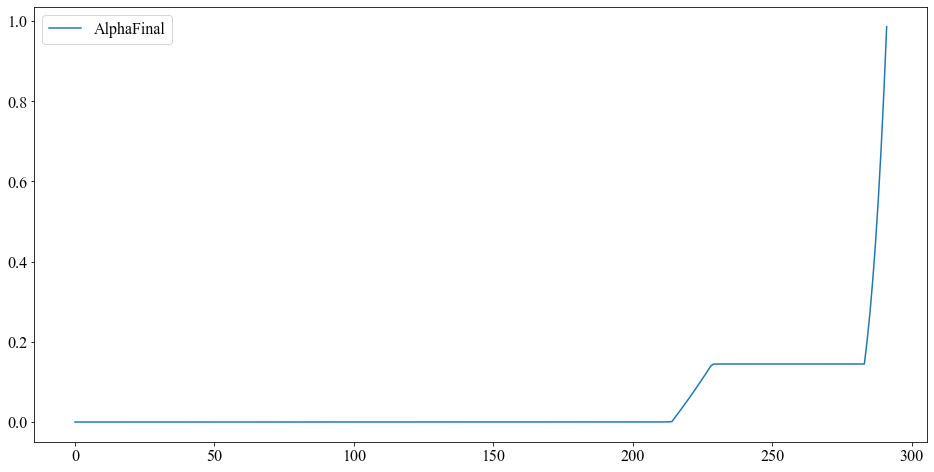

In [1062]:
params_beam["beta"] = 0.5
params_beam["theta"] = 0.5
# >>>>>>>>>>>>>>>>>
repairGap = 5  #>>
# >>>>>>>>>>>>>>>>>
alphaFinal = []

"""
- First Time Simulation
"""
rectangular_beam = Beam(**params_beam)
deadLoadSingle = rectangular_beam.calculateDeadLoadSingle()
sustainedLiveLoad_year = rectangular_beam.calculateSustainedLiveLoad_year(duration_year=6000)
sigmaT_year = rectangular_beam.calculateSigmaT(deadLoadSingle, sustainedLiveLoad_year)

# Crack Depth
lam = rectangular_beam.calculateLambda()
deltaT_year = rectangular_beam.calculateDeltaT_year(duration_year=2000)
# Strength Degradation
a = rectangular_beam.calculateA()
R_year = rectangular_beam.calculateR_year(duration_year=2000)
sigmaS_year = rectangular_beam.calculateSigmaS_year(duration_year=2000)
# AlphaRate and Alpha
alphaRate, Alpha = rectangular_beam.calculateAlpha(sigmaT=sigmaT_year[:2000], sigmaS=sigmaS_year)

alphaFinal += list(Alpha[:repairGap])


"""
Second Time Simulation
"""
sigmaT_year2 = sigmaT_year[repairGap:]
rectangular_beam2 = Beam(**params_beam)
# Crack Depth
lam2 = rectangular_beam2.calculateLambda()
deltaT_year2 = rectangular_beam2.calculateDeltaT_year(duration_year=2000)
# Strength Degradation
a2 = rectangular_beam2.calculateA()
R_year2 = rectangular_beam2.calculateR_year(duration_year=2000)
sigmaS_year2 = rectangular_beam2.calculateSigmaS_year(duration_year=2000)
# AlphaRate and Alpha
alphaRate2, Alpha2 = rectangular_beam2.calculateAlpha(sigmaT=sigmaT_year2[:2000], sigmaS=sigmaS_year2)

alphaFinal += list(Alpha2[:repairGap])

"""
Third Time Simulation
"""
sigmaT_year3 = sigmaT_year2[alphaFirstIndex2:]
rectangular_beam3 = Beam(**params_beam)
# Crack Depth
lam3 = rectangular_beam3.calculateLambda()
deltaT_year3 = rectangular_beam3.calculateDeltaT_year(duration_year=2000)
# Strength Degradation
a3 = rectangular_beam3.calculateA()
R_year3 = rectangular_beam3.calculateR_year(duration_year=2000)
sigmaS_year3 = rectangular_beam3.calculateSigmaS_year(duration_year=2000)
# AlphaRate and Alpha
alphaRate3, Alpha3 = rectangular_beam3.calculateAlpha(sigmaT=sigmaT_year3[:2000], sigmaS=sigmaS_year3)

alphaFinal += list(Alpha3)

# Find Index When AlphaFinal Reaches 1
for index in range(len(alphaFinal)):
    if alphaFinal[index] > 1:
        indexFinal = index
        break



fig = plt.figure(figsize=(16, 8))
plt.plot(alphaFinal[:indexFinal], label="AlphaFinal")
# plt.plot(Alpha[:indexFinal])
# plt.plot(Alpha[:alphaFirstIndex], label="First Alpha Segmentation")
# plt.plot(Alpha2[:alphaFirstIndex2], label="Second Alpha Segmentation")
# plt.plot(Alpha2[:alphaFirstIndex3], label="Third Alpha Segmentation")
plt.legend()
plt.title("")
plt.xlabel("")
plt.ylabel("")

Simulation Times:  1
Simulation Times:  101
Simulation Times:  201
Simulation Times:  301
Simulation Times:  401
Simulation Times:  501
Simulation Times:  601
Simulation Times:  701
Simulation Times:  801
Simulation Times:  901

Average Year of Alpha Reaching 1: 308.902


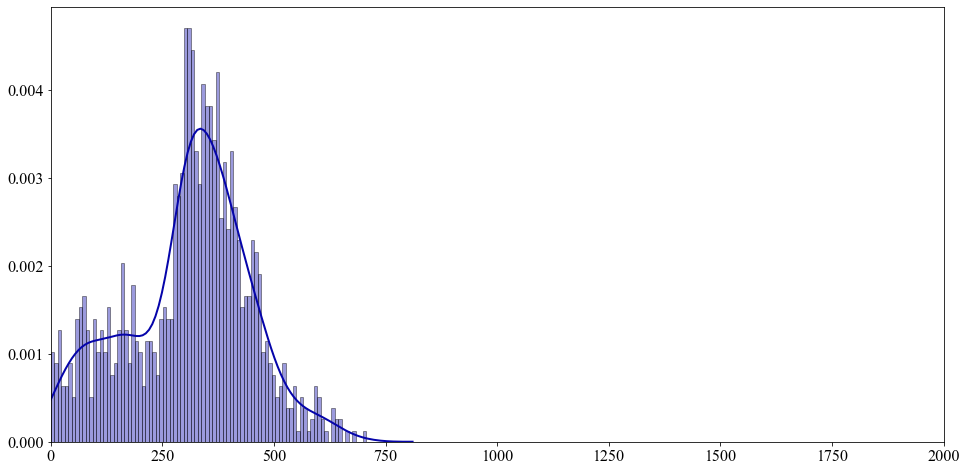

In [1063]:
simulationTimes = 1000
alphaIndexAll = []
fig = plt.figure(figsize=(16, 8))

for time in range(simulationTimes):
    if time % 100 == 0:
        print("Simulation Times: ", time+1)
        
    params_beam["beta"] = 0.5
    params_beam["theta"] = 0.5
    # >>>>>>>>>>>>>>>>>
    repairGap = 5  #>>
    # >>>>>>>>>>>>>>>>>
    alphaFinal = []

    """
    - First Time Simulation
    """
    rectangular_beam = Beam(**params_beam)
    deadLoadSingle = rectangular_beam.calculateDeadLoadSingle()
    sustainedLiveLoad_year = rectangular_beam.calculateSustainedLiveLoad_year(duration_year=6000)
    sigmaT_year = rectangular_beam.calculateSigmaT(deadLoadSingle, sustainedLiveLoad_year)

    # Crack Depth
    lam = rectangular_beam.calculateLambda()
    deltaT_year = rectangular_beam.calculateDeltaT_year(duration_year=2000)
    # Strength Degradation
    a = rectangular_beam.calculateA()
    R_year = rectangular_beam.calculateR_year(duration_year=2000)
    sigmaS_year = rectangular_beam.calculateSigmaS_year(duration_year=2000)
    # AlphaRate and Alpha
    alphaRate, Alpha = rectangular_beam.calculateAlpha(sigmaT=sigmaT_year[:2000], sigmaS=sigmaS_year)

    alphaFinal += list(Alpha[:repairGap])


    """
    Second Time Simulation
    """
    sigmaT_year2 = sigmaT_year[repairGap:]
    rectangular_beam2 = Beam(**params_beam)
    # Crack Depth
    lam2 = rectangular_beam2.calculateLambda()
    deltaT_year2 = rectangular_beam2.calculateDeltaT_year(duration_year=2000)
    # Strength Degradation
    a2 = rectangular_beam2.calculateA()
    R_year2 = rectangular_beam2.calculateR_year(duration_year=2000)
    sigmaS_year2 = rectangular_beam2.calculateSigmaS_year(duration_year=2000)
    # AlphaRate and Alpha
    alphaRate2, Alpha2 = rectangular_beam2.calculateAlpha(sigmaT=sigmaT_year2[:2000], sigmaS=sigmaS_year2)

    alphaFinal += list(Alpha2[:repairGap])

    """
    Third Time Simulation
    """
    sigmaT_year3 = sigmaT_year2[alphaFirstIndex2:]
    rectangular_beam3 = Beam(**params_beam)
    # Crack Depth
    lam3 = rectangular_beam3.calculateLambda()
    deltaT_year3 = rectangular_beam3.calculateDeltaT_year(duration_year=2000)
    # Strength Degradation
    a3 = rectangular_beam3.calculateA()
    R_year3 = rectangular_beam3.calculateR_year(duration_year=2000)
    sigmaS_year3 = rectangular_beam3.calculateSigmaS_year(duration_year=2000)
    # AlphaRate and Alpha
    alphaRate3, Alpha3 = rectangular_beam3.calculateAlpha(sigmaT=sigmaT_year3[:2000], sigmaS=sigmaS_year3)

    alphaFinal += list(Alpha3)

    # Find Index When AlphaFinal Reaches 1
    for index in range(len(alphaFinal)):
        if alphaFinal[index] > 1:
            indexFinal = index
            break

    alphaIndexAll.append(indexFinal)

sns.distplot(alphaIndexAll, hist=True, kde=True, 
             bins=int(180/2), color = '#0504aa', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.xlim(0, 2000)
plt.title("")
plt.xlabel("")
plt.ylabel("")
print(f"\nAverage Year of Alpha Reaching 1: {np.mean(alphaIndexAll)}")

alphaIndexAllFiveYearRepairment_twice = alphaIndexAll

## 15 - Reliability Probability Comparison All

Text(0, 0.5, '')

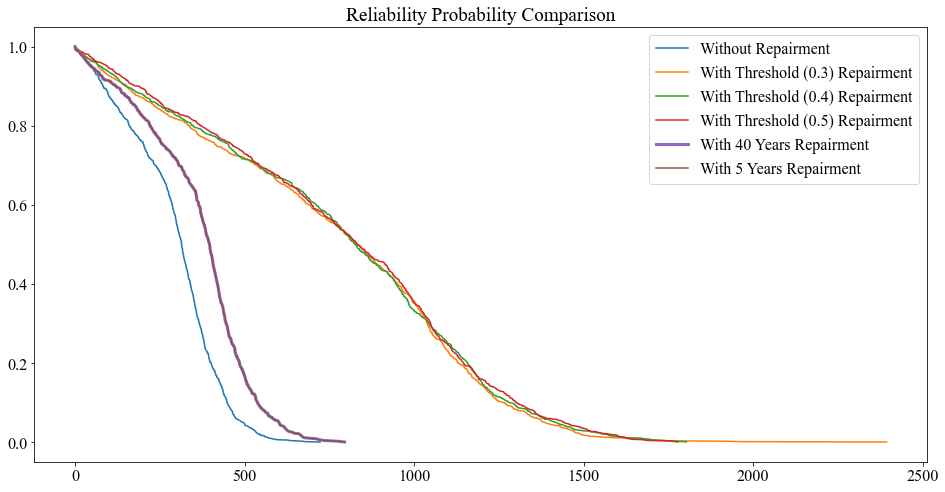

In [1043]:
# CDF Figure
# Origin
fig = plt.figure(figsize=(16, 8))
alphaIndexAllOrigin.sort()
N = len(alphaIndexAllOrigin)
y = np.arange(N) / float(N)
plt.plot(alphaIndexAllOrigin, 1 - y, label="Without Repairment")

# Threshold Repairment - 0.3
alphaIndexAllWithThresholdRepairment_3.sort()
N4 = len(alphaIndexAllWithThresholdRepairment_3)
y4 = np.arange(N4) / float(N4)
plt.plot(alphaIndexAllWithThresholdRepairment_3, 1 - y4, label="With Threshold (0.3) Repairment")

# Threshold Repairment - 0.4
alphaIndexAllWithThresholdRepairment_4.sort()
N5 = len(alphaIndexAllWithThresholdRepairment_4)
y5 = np.arange(N5) / float(N5)
plt.plot(alphaIndexAllWithThresholdRepairment_4, 1 - y5, label="With Threshold (0.4) Repairment")

# Threshold Repairment - 0.5
alphaIndexAllWithThresholdRepairment.sort()
N1 = len(alphaIndexAllWithThresholdRepairment)
y1 = np.arange(N1) / float(N1)
plt.plot(alphaIndexAllWithThresholdRepairment, 1 - y1, label="With Threshold (0.5) Repairment")

# 40 years Repairment
alphaIndexAllFourtyYearRepairment.sort()
N2 = len(alphaIndexAllFourtyYearRepairment)
y2 = np.arange(N2) / float(N2)
plt.plot(alphaIndexAllFourtyYearRepairment, 1 - y2, linewidth=3, label="With 40 Years Repairment")

# 5 years Repairment
alphaIndexAllFiveYearRepairment.sort()
N3 = len(alphaIndexAllFiveYearRepairment)
y3 = np.arange(N3) / float(N3)
plt.plot(alphaIndexAllFiveYearRepairment, 1 - y3, label="With 5 Years Repairment")


plt.legend()
plt.title("Reliability Probability Comparison")
plt.xlabel("")
plt.ylabel("")

## 16 - Repairment Only Once

### Threshold: 0.5

Simulation Times:  1
Simulation Times:  101
Simulation Times:  201
Simulation Times:  301
Simulation Times:  401
Simulation Times:  501
Simulation Times:  601
Simulation Times:  701
Simulation Times:  801
Simulation Times:  901

Average Year of Alpha Reaching 1: 541.308


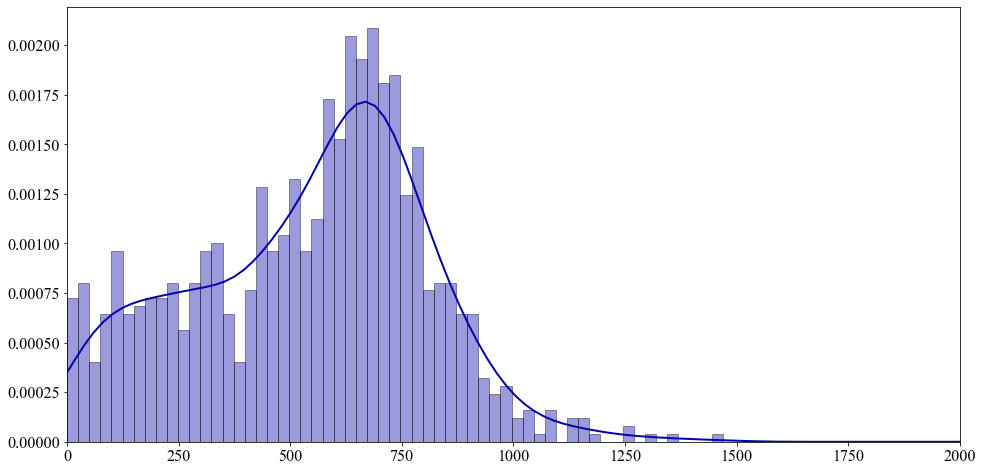

In [1046]:
simulationTimes = 1000
alphaIndexAll = []
fig = plt.figure(figsize=(16, 8))


for time in range(simulationTimes):
    if time % 100 == 0:
        print("Simulation Times: ", time+1)

    params_beam["beta"] = 0.5
    params_beam["theta"] = 0.5
    # >>>>>>>>>>>>>>>>>>>>>>>
    alphaThreshold = 0.5 #>>>
    # >>>>>>>>>>>>>>>>>>>>>>>
    alphaFinal = []

    """
    - First Time Simulation
    """
    rectangular_beam = Beam(**params_beam)
    deadLoadSingle = rectangular_beam.calculateDeadLoadSingle()
    sustainedLiveLoad_year = rectangular_beam.calculateSustainedLiveLoad_year(duration_year=6000)
    sigmaT_year = rectangular_beam.calculateSigmaT(deadLoadSingle, sustainedLiveLoad_year)

    # Crack Depth
    lam = rectangular_beam.calculateLambda()
    deltaT_year = rectangular_beam.calculateDeltaT_year(duration_year=2000)
    # Strength Degradation
    a = rectangular_beam.calculateA()
    R_year = rectangular_beam.calculateR_year(duration_year=2000)
    sigmaS_year = rectangular_beam.calculateSigmaS_year(duration_year=2000)
    # AlphaRate and Alpha
    alphaRate, Alpha = rectangular_beam.calculateAlpha(sigmaT=sigmaT_year[:2000], sigmaS=sigmaS_year)

    for index in range(len(Alpha)):
        if Alpha[index] > alphaThreshold:
            alphaFirstIndex = index
            alphaFinal += list(Alpha[:alphaFirstIndex])
            break


    """
    Second Time Simulation
    """
    sigmaT_year2 = sigmaT_year[alphaFirstIndex:]
    rectangular_beam2 = Beam(**params_beam)
    # Crack Depth
    lam2 = rectangular_beam2.calculateLambda()
    deltaT_year2 = rectangular_beam2.calculateDeltaT_year(duration_year=2000)
    # Strength Degradation
    a2 = rectangular_beam2.calculateA()
    R_year2 = rectangular_beam2.calculateR_year(duration_year=2000)
    sigmaS_year2 = rectangular_beam2.calculateSigmaS_year(duration_year=2000)
    # AlphaRate and Alpha
    alphaRate2, Alpha2 = rectangular_beam2.calculateAlpha(sigmaT=sigmaT_year2[:2000], sigmaS=sigmaS_year2)

    for index2 in range(len(Alpha2)):
        if Alpha2[index2] > alphaThreshold:
            alphaFirstIndex2 = index2
            alphaFinal += list(Alpha2)
            break

    # Find Index When AlphaFinal Reaches 1
    for index in range(len(alphaFinal)):
        if alphaFinal[index] > 1:
            indexFinal = index
            break

    alphaIndexAll.append(indexFinal)

sns.distplot(alphaIndexAll, hist=True, kde=True, 
             bins=int(180/2), color = '#0504aa', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.xlim(0, 2000)
plt.title("")
plt.xlabel("")
plt.ylabel("")
print(f"\nAverage Year of Alpha Reaching 1: {np.mean(alphaIndexAll)}")

alphaIndexAllWithThresholdRepairment = alphaIndexAll

### Threshold: 0.4

Simulation Times:  1
Simulation Times:  101
Simulation Times:  201
Simulation Times:  301
Simulation Times:  401
Simulation Times:  501
Simulation Times:  601
Simulation Times:  701
Simulation Times:  801
Simulation Times:  901

Average Year of Alpha Reaching 1: 540.519


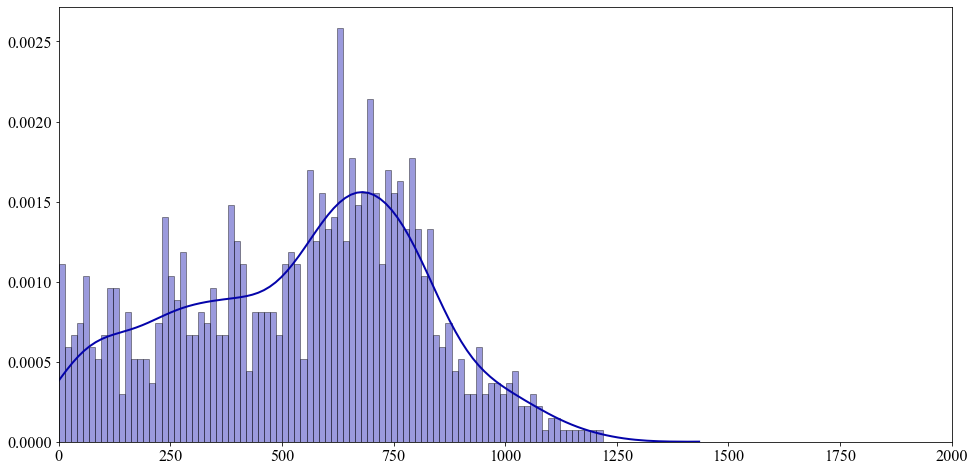

In [1047]:
simulationTimes = 1000
alphaIndexAll = []
fig = plt.figure(figsize=(16, 8))


for time in range(simulationTimes):
    if time % 100 == 0:
        print("Simulation Times: ", time+1)
    


    params_beam["beta"] = 0.5
    params_beam["theta"] = 0.5
    # >>>>>>>>>>>>>>>>>>>>>>>>>
    alphaThreshold = 0.4  #>>>>
    # >>>>>>>>>>>>>>>>>>>>>>>>>
    alphaFinal = []

    """
    - First Time Simulation
    """
    rectangular_beam = Beam(**params_beam)
    deadLoadSingle = rectangular_beam.calculateDeadLoadSingle()
    sustainedLiveLoad_year = rectangular_beam.calculateSustainedLiveLoad_year(duration_year=6000)
    sigmaT_year = rectangular_beam.calculateSigmaT(deadLoadSingle, sustainedLiveLoad_year)

    # Crack Depth
    lam = rectangular_beam.calculateLambda()
    deltaT_year = rectangular_beam.calculateDeltaT_year(duration_year=2000)
    # Strength Degradation
    a = rectangular_beam.calculateA()
    R_year = rectangular_beam.calculateR_year(duration_year=2000)
    sigmaS_year = rectangular_beam.calculateSigmaS_year(duration_year=2000)
    # AlphaRate and Alpha
    alphaRate, Alpha = rectangular_beam.calculateAlpha(sigmaT=sigmaT_year[:2000], sigmaS=sigmaS_year)

    for index in range(len(Alpha)):
        if Alpha[index] > alphaThreshold:
            alphaFirstIndex = index
            alphaFinal += list(Alpha[:alphaFirstIndex])
            break


    """
    Second Time Simulation
    """
    sigmaT_year2 = sigmaT_year[alphaFirstIndex:]
    rectangular_beam2 = Beam(**params_beam)
    # Crack Depth
    lam2 = rectangular_beam2.calculateLambda()
    deltaT_year2 = rectangular_beam2.calculateDeltaT_year(duration_year=2000)
    # Strength Degradation
    a2 = rectangular_beam2.calculateA()
    R_year2 = rectangular_beam2.calculateR_year(duration_year=2000)
    sigmaS_year2 = rectangular_beam2.calculateSigmaS_year(duration_year=2000)
    # AlphaRate and Alpha
    alphaRate2, Alpha2 = rectangular_beam2.calculateAlpha(sigmaT=sigmaT_year2[:2000], sigmaS=sigmaS_year2)

    for index2 in range(len(Alpha2)):
        if Alpha2[index2] > alphaThreshold:
            alphaFirstIndex2 = index2
            alphaFinal += list(Alpha2)
            break

    # Find Index When AlphaFinal Reaches 1
    for index in range(len(alphaFinal)):
        if alphaFinal[index] > 1:
            indexFinal = index
            break

    alphaIndexAll.append(indexFinal)

sns.distplot(alphaIndexAll, hist=True, kde=True, 
             bins=int(180/2), color = '#0504aa', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.xlim(0, 2000)
plt.title("")
plt.xlabel("")
plt.ylabel("")
print(f"\nAverage Year of Alpha Reaching 1: {np.mean(alphaIndexAll)}")

alphaIndexAllWithThresholdRepairment_4 = alphaIndexAll

### Threshold: 0.3

Simulation Times:  1
Simulation Times:  101
Simulation Times:  201
Simulation Times:  301
Simulation Times:  401
Simulation Times:  501
Simulation Times:  601
Simulation Times:  701
Simulation Times:  801
Simulation Times:  901

Average Year of Alpha Reaching 1: 550.001


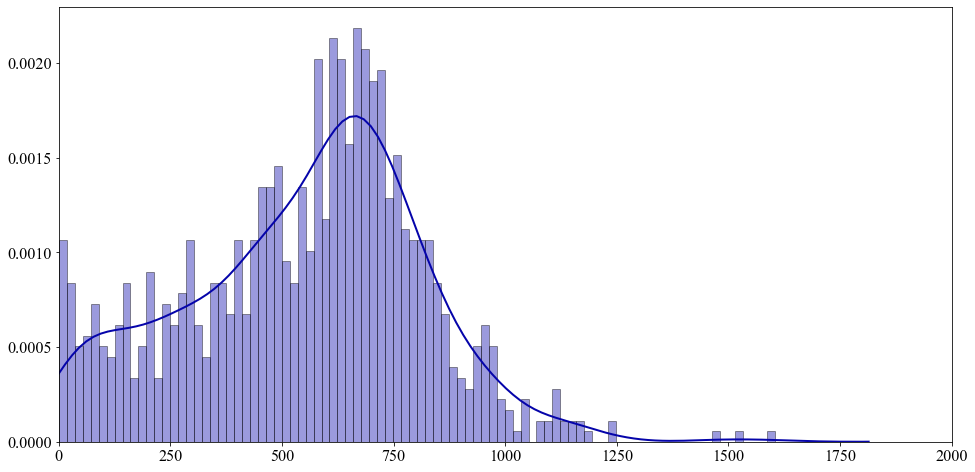

In [1048]:
simulationTimes = 1000
alphaIndexAll = []
fig = plt.figure(figsize=(16, 8))


for time in range(simulationTimes):
    if time % 100 == 0:
        print("Simulation Times: ", time+1)
    


    params_beam["beta"] = 0.5
    params_beam["theta"] = 0.5
    # >>>>>>>>>>>>>>>>>>>>>>>>
    alphaThreshold = 0.3  # >>
    # >>>>>>>>>>>>>>>>>>>>>>>>
    alphaFinal = []

    """
    - First Time Simulation
    """
    rectangular_beam = Beam(**params_beam)
    deadLoadSingle = rectangular_beam.calculateDeadLoadSingle()
    sustainedLiveLoad_year = rectangular_beam.calculateSustainedLiveLoad_year(duration_year=6000)
    sigmaT_year = rectangular_beam.calculateSigmaT(deadLoadSingle, sustainedLiveLoad_year)

    # Crack Depth
    lam = rectangular_beam.calculateLambda()
    deltaT_year = rectangular_beam.calculateDeltaT_year(duration_year=2000)
    # Strength Degradation
    a = rectangular_beam.calculateA()
    R_year = rectangular_beam.calculateR_year(duration_year=2000)
    sigmaS_year = rectangular_beam.calculateSigmaS_year(duration_year=2000)
    # AlphaRate and Alpha
    alphaRate, Alpha = rectangular_beam.calculateAlpha(sigmaT=sigmaT_year[:2000], sigmaS=sigmaS_year)

    for index in range(len(Alpha)):
        if Alpha[index] > alphaThreshold:
            alphaFirstIndex = index
            alphaFinal += list(Alpha[:alphaFirstIndex])
            break


    """
    Second Time Simulation
    """
    sigmaT_year2 = sigmaT_year[alphaFirstIndex:]
    rectangular_beam2 = Beam(**params_beam)
    # Crack Depth
    lam2 = rectangular_beam2.calculateLambda()
    deltaT_year2 = rectangular_beam2.calculateDeltaT_year(duration_year=2000)
    # Strength Degradation
    a2 = rectangular_beam2.calculateA()
    R_year2 = rectangular_beam2.calculateR_year(duration_year=2000)
    sigmaS_year2 = rectangular_beam2.calculateSigmaS_year(duration_year=2000)
    # AlphaRate and Alpha
    alphaRate2, Alpha2 = rectangular_beam2.calculateAlpha(sigmaT=sigmaT_year2[:2000], sigmaS=sigmaS_year2)

    for index2 in range(len(Alpha2)):
        if Alpha2[index2] > alphaThreshold:
            alphaFirstIndex2 = index2
            alphaFinal += list(Alpha2)
            break

    # Find Index When AlphaFinal Reaches 1
    for index in range(len(alphaFinal)):
        if alphaFinal[index] > 1:
            indexFinal = index
            break

    alphaIndexAll.append(indexFinal)

sns.distplot(alphaIndexAll, hist=True, kde=True, 
             bins=int(180/2), color = '#0504aa', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.xlim(0, 2000)
plt.title("")
plt.xlabel("")
plt.ylabel("")
print(f"\nAverage Year of Alpha Reaching 1: {np.mean(alphaIndexAll)}")

alphaIndexAllWithThresholdRepairment_3 = alphaIndexAll

### Repairment Every 40 years

Simulation Times:  1
Simulation Times:  101
Simulation Times:  201
Simulation Times:  301
Simulation Times:  401
Simulation Times:  501
Simulation Times:  601
Simulation Times:  701
Simulation Times:  801
Simulation Times:  901

Average Year of Alpha Reaching 1: 322.059


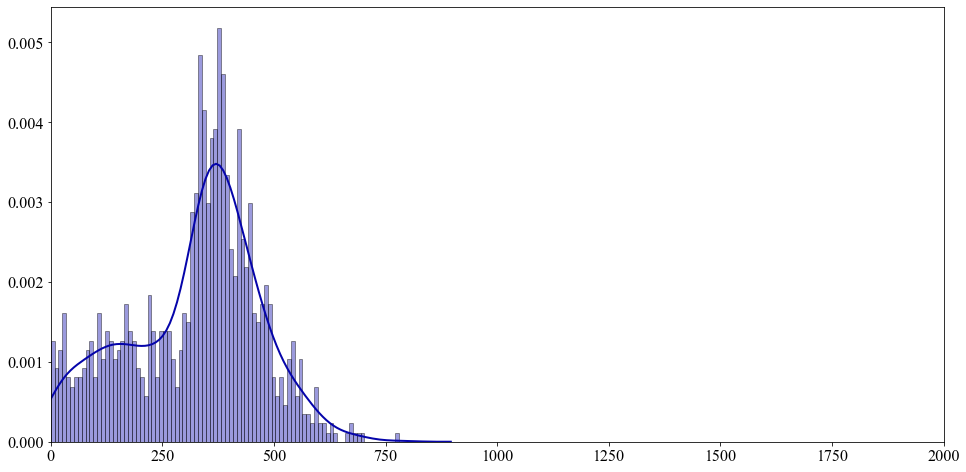

In [1049]:
simulationTimes = 1000
alphaIndexAll = []
fig = plt.figure(figsize=(16, 8))

for time in range(simulationTimes):
    if time % 100 == 0:
        print("Simulation Times: ", time+1)
        
    params_beam["beta"] = 0.5
    params_beam["theta"] = 0.5
    # >>>>>>>>>>>>>>>>>>
    repairGap = 40  # >>
    # >>>>>>>>>>>>>>>>>>
    alphaFinal = []

    """
    - First Time Simulation
    """
    rectangular_beam = Beam(**params_beam)
    deadLoadSingle = rectangular_beam.calculateDeadLoadSingle()
    sustainedLiveLoad_year = rectangular_beam.calculateSustainedLiveLoad_year(duration_year=6000)
    sigmaT_year = rectangular_beam.calculateSigmaT(deadLoadSingle, sustainedLiveLoad_year)

    # Crack Depth
    lam = rectangular_beam.calculateLambda()
    deltaT_year = rectangular_beam.calculateDeltaT_year(duration_year=2000)
    # Strength Degradation
    a = rectangular_beam.calculateA()
    R_year = rectangular_beam.calculateR_year(duration_year=2000)
    sigmaS_year = rectangular_beam.calculateSigmaS_year(duration_year=2000)
    # AlphaRate and Alpha
    alphaRate, Alpha = rectangular_beam.calculateAlpha(sigmaT=sigmaT_year[:2000], sigmaS=sigmaS_year)

    alphaFinal += list(Alpha[:repairGap])


    """
    Second Time Simulation
    """
    sigmaT_year2 = sigmaT_year[repairGap:]
    rectangular_beam2 = Beam(**params_beam)
    # Crack Depth
    lam2 = rectangular_beam2.calculateLambda()
    deltaT_year2 = rectangular_beam2.calculateDeltaT_year(duration_year=2000)
    # Strength Degradation
    a2 = rectangular_beam2.calculateA()
    R_year2 = rectangular_beam2.calculateR_year(duration_year=2000)
    sigmaS_year2 = rectangular_beam2.calculateSigmaS_year(duration_year=2000)
    # AlphaRate and Alpha
    alphaRate2, Alpha2 = rectangular_beam2.calculateAlpha(sigmaT=sigmaT_year2[:2000], sigmaS=sigmaS_year2)

    alphaFinal += list(Alpha2)

    # Find Index When AlphaFinal Reaches 1
    for index in range(len(alphaFinal)):
        if alphaFinal[index] > 1:
            indexFinal = index
            break

    alphaIndexAll.append(indexFinal)

sns.distplot(alphaIndexAll, hist=True, kde=True, 
             bins=int(180/2), color = '#0504aa', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.xlim(0, 2000)
plt.title("")
plt.xlabel("")
plt.ylabel("")
print(f"\nAverage Year of Alpha Reaching 1: {np.mean(alphaIndexAll)}")

alphaIndexAllFourtyYearRepairment = alphaIndexAll

### Repairment Every 5 Years

Simulation Times:  1
Simulation Times:  101
Simulation Times:  201
Simulation Times:  301
Simulation Times:  401
Simulation Times:  501
Simulation Times:  601
Simulation Times:  701
Simulation Times:  801
Simulation Times:  901

Average Year of Alpha Reaching 1: 301.309


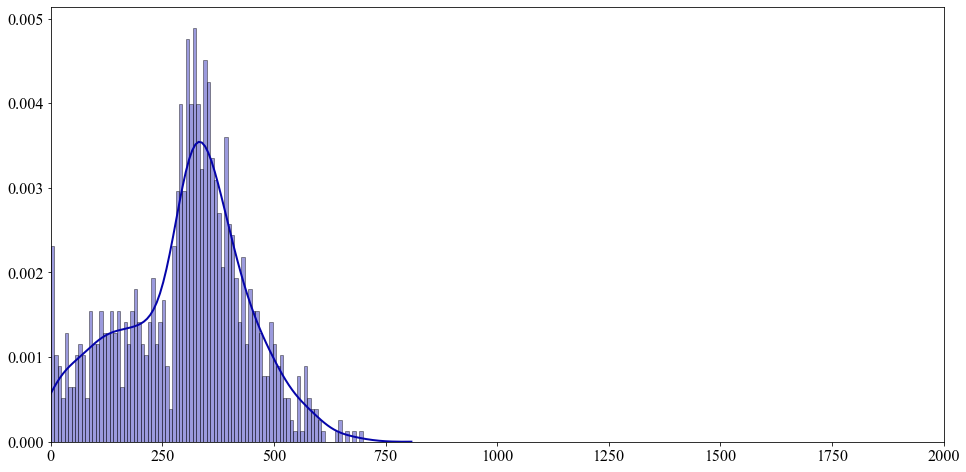

In [1051]:
simulationTimes = 1000
alphaIndexAll = []
fig = plt.figure(figsize=(16, 8))

for time in range(simulationTimes):
    if time % 100 == 0:
        print("Simulation Times: ", time+1)
        
    params_beam["beta"] = 0.5
    params_beam["theta"] = 0.5
    # >>>>>>>>>>>>>>>>>
    repairGap = 5   #>>
    # >>>>>>>>>>>>>>>>>
    alphaFinal = []

    """
    - First Time Simulation
    """
    rectangular_beam = Beam(**params_beam)
    deadLoadSingle = rectangular_beam.calculateDeadLoadSingle()
    sustainedLiveLoad_year = rectangular_beam.calculateSustainedLiveLoad_year(duration_year=6000)
    sigmaT_year = rectangular_beam.calculateSigmaT(deadLoadSingle, sustainedLiveLoad_year)

    # Crack Depth
    lam = rectangular_beam.calculateLambda()
    deltaT_year = rectangular_beam.calculateDeltaT_year(duration_year=2000)
    # Strength Degradation
    a = rectangular_beam.calculateA()
    R_year = rectangular_beam.calculateR_year(duration_year=2000)
    sigmaS_year = rectangular_beam.calculateSigmaS_year(duration_year=2000)
    # AlphaRate and Alpha
    alphaRate, Alpha = rectangular_beam.calculateAlpha(sigmaT=sigmaT_year[:2000], sigmaS=sigmaS_year)

    alphaFinal += list(Alpha[:repairGap])


    """
    Second Time Simulation
    """
    sigmaT_year2 = sigmaT_year[repairGap:]
    rectangular_beam2 = Beam(**params_beam)
    # Crack Depth
    lam2 = rectangular_beam2.calculateLambda()
    deltaT_year2 = rectangular_beam2.calculateDeltaT_year(duration_year=2000)
    # Strength Degradation
    a2 = rectangular_beam2.calculateA()
    R_year2 = rectangular_beam2.calculateR_year(duration_year=2000)
    sigmaS_year2 = rectangular_beam2.calculateSigmaS_year(duration_year=2000)
    # AlphaRate and Alpha
    alphaRate2, Alpha2 = rectangular_beam2.calculateAlpha(sigmaT=sigmaT_year2[:2000], sigmaS=sigmaS_year2)

    alphaFinal += list(Alpha2)

    # Find Index When AlphaFinal Reaches 1
    for index in range(len(alphaFinal)):
        if alphaFinal[index] > 1:
            indexFinal = index
            break

    alphaIndexAll.append(indexFinal)

sns.distplot(alphaIndexAll, hist=True, kde=True, 
             bins=int(180/2), color = '#0504aa', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.xlim(0, 2000)
plt.title("")
plt.xlabel("")
plt.ylabel("")
print(f"\nAverage Year of Alpha Reaching 1: {np.mean(alphaIndexAll)}")

alphaIndexAllFiveYearRepairment = alphaIndexAll

Text(0, 0.5, '')

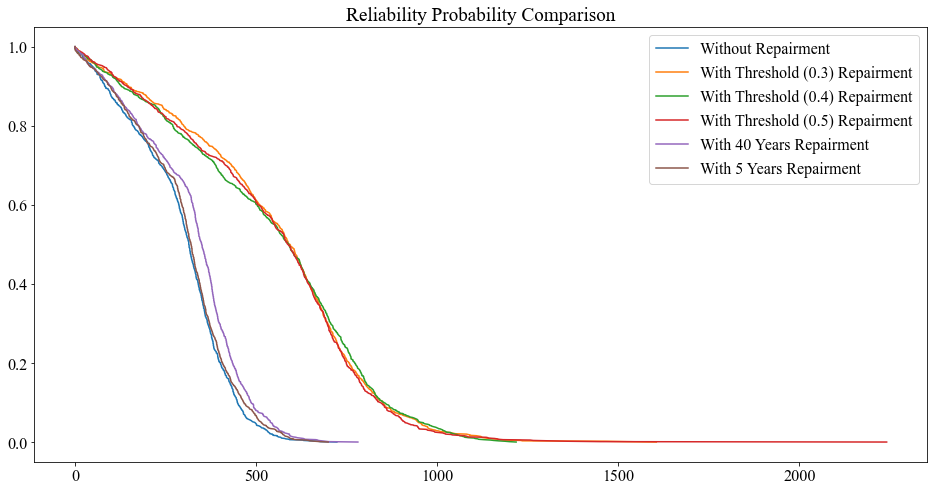

In [1055]:
# CDF Figure
# Origin
fig = plt.figure(figsize=(16, 8))
alphaIndexAllOrigin.sort()
N = len(alphaIndexAllOrigin)
y = np.arange(N) / float(N)
plt.plot(alphaIndexAllOrigin, 1 - y, label="Without Repairment")

# Threshold Repairment - 0.3
alphaIndexAllWithThresholdRepairment_3.sort()
N4 = len(alphaIndexAllWithThresholdRepairment_3)
y4 = np.arange(N4) / float(N4)
plt.plot(alphaIndexAllWithThresholdRepairment_3, 1 - y4, label="With Threshold (0.3) Repairment")

# Threshold Repairment - 0.4
alphaIndexAllWithThresholdRepairment_4.sort()
N5 = len(alphaIndexAllWithThresholdRepairment_4)
y5 = np.arange(N5) / float(N5)
plt.plot(alphaIndexAllWithThresholdRepairment_4, 1 - y5, label="With Threshold (0.4) Repairment")

# Threshold Repairment - 0.5
alphaIndexAllWithThresholdRepairment.sort()
N1 = len(alphaIndexAllWithThresholdRepairment)
y1 = np.arange(N1) / float(N1)
plt.plot(alphaIndexAllWithThresholdRepairment, 1 - y1, label="With Threshold (0.5) Repairment")

# 40 years Repairment
alphaIndexAllFourtyYearRepairment.sort()
N2 = len(alphaIndexAllFourtyYearRepairment)
y2 = np.arange(N2) / float(N2)
plt.plot(alphaIndexAllFourtyYearRepairment, 1 - y2, label="With 40 Years Repairment")

# 5 years Repairment
alphaIndexAllFiveYearRepairment.sort()
N3 = len(alphaIndexAllFiveYearRepairment)
y3 = np.arange(N3) / float(N3)
plt.plot(alphaIndexAllFiveYearRepairment, 1 - y3, label="With 5 Years Repairment")


plt.legend()
plt.title("Reliability Probability Comparison")
plt.xlabel("")
plt.ylabel("")

## Repairment Comparison

Text(0, 0.5, '')

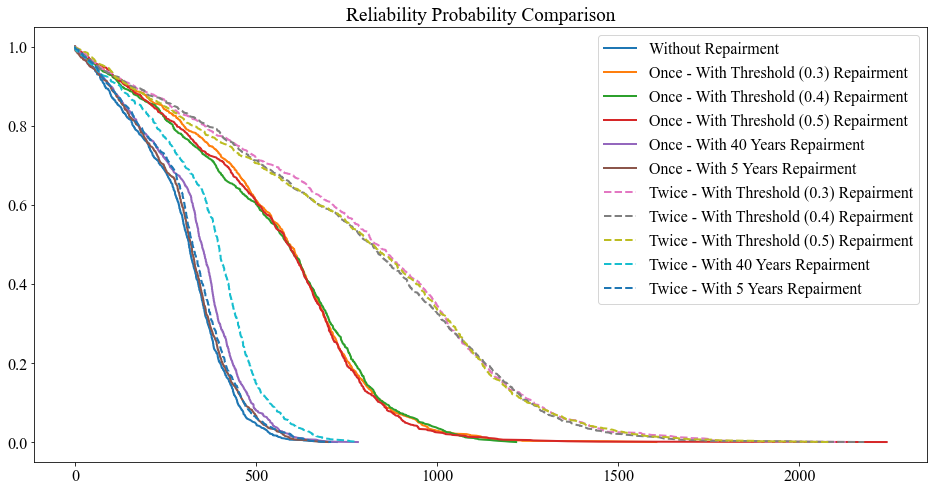

In [1066]:
# CDF Figure

# REPAIR ONCE
# Origin
fig = plt.figure(figsize=(16, 8))
alphaIndexAllOrigin.sort()
N = len(alphaIndexAllOrigin)
y = np.arange(N) / float(N)
plt.plot(alphaIndexAllOrigin, 1 - y, linewidth=2, label="Without Repairment")

# Threshold Repairment - 0.3
alphaIndexAllWithThresholdRepairment_3.sort()
N4 = len(alphaIndexAllWithThresholdRepairment_3)
y4 = np.arange(N4) / float(N4)
plt.plot(alphaIndexAllWithThresholdRepairment_3, 1 - y4, linewidth=2, label="Once - With Threshold (0.3) Repairment")

# Threshold Repairment - 0.4
alphaIndexAllWithThresholdRepairment_4.sort()
N5 = len(alphaIndexAllWithThresholdRepairment_4)
y5 = np.arange(N5) / float(N5)
plt.plot(alphaIndexAllWithThresholdRepairment_4, 1 - y5, linewidth=2, label="Once - With Threshold (0.4) Repairment")

# Threshold Repairment - 0.5
alphaIndexAllWithThresholdRepairment.sort()
N1 = len(alphaIndexAllWithThresholdRepairment)
y1 = np.arange(N1) / float(N1)
plt.plot(alphaIndexAllWithThresholdRepairment, 1 - y1, linewidth=2, label="Once - With Threshold (0.5) Repairment")

# 40 years Repairment
alphaIndexAllFourtyYearRepairment.sort()
N2 = len(alphaIndexAllFourtyYearRepairment)
y2 = np.arange(N2) / float(N2)
plt.plot(alphaIndexAllFourtyYearRepairment, 1 - y2, linewidth=2, label="Once - With 40 Years Repairment")

# 5 years Repairment
alphaIndexAllFiveYearRepairment.sort()
N3 = len(alphaIndexAllFiveYearRepairment)
y3 = np.arange(N3) / float(N3)
plt.plot(alphaIndexAllFiveYearRepairment, 1 - y3, linewidth=2, label="Once - With 5 Years Repairment")


# REPAIR TWICE
# Threshold Repairment - 0.3
alphaIndexAllWithThresholdRepairment_3_twice.sort()
N6 = len(alphaIndexAllWithThresholdRepairment_3_twice)
y6 = np.arange(N6) / float(N6)
plt.plot(alphaIndexAllWithThresholdRepairment_3_twice, 1 - y6, '--', linewidth=2, label="Twice - With Threshold (0.3) Repairment")

# Threshold Repairment - 0.4
alphaIndexAllWithThresholdRepairment_4_twice.sort()
N7 = len(alphaIndexAllWithThresholdRepairment_4_twice)
y7 = np.arange(N7) / float(N7)
plt.plot(alphaIndexAllWithThresholdRepairment_4_twice, 1 - y7, '--', linewidth=2, label="Twice - With Threshold (0.4) Repairment")

# Threshold Repairment - 0.5
alphaIndexAllWithThresholdRepairment_twice.sort()
N8 = len(alphaIndexAllWithThresholdRepairment)
y8 = np.arange(N8) / float(N8)
plt.plot(alphaIndexAllWithThresholdRepairment_twice, 1 - y8, '--', linewidth=2, label="Twice - With Threshold (0.5) Repairment")

# 40 years Repairment
alphaIndexAllFourtyYearRepairment_twice.sort()
N9 = len(alphaIndexAllFourtyYearRepairment_twice)
y9 = np.arange(N9) / float(N9)
plt.plot(alphaIndexAllFourtyYearRepairment_twice, 1 - y9, '--', linewidth=2, label="Twice - With 40 Years Repairment")

# 5 years Repairment
alphaIndexAllFiveYearRepairment_twice.sort()
N10 = len(alphaIndexAllFiveYearRepairment_twice)
y10 = np.arange(N10) / float(N10)
plt.plot(alphaIndexAllFiveYearRepairment_twice, 1 - y10, '--', linewidth=2, label="Twice - With 5 Years Repairment")


plt.legend()
plt.title("Reliability Probability Comparison")
plt.xlabel("")
plt.ylabel("")